# Libraries

In [45]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from tqdm.notebook import tqdm
import math
from scipy.ndimage import convolve
from scipy.linalg import null_space
import pickle

# Functions

In [80]:
def get_bgr_frequencies(image):
    """
    Calculates the frequency of each color intensity level (0-255) for the blue, green, and red channels in a given image.

    Parameters:
    image (list of list of [int, int, int]): A 2D list or array of pixels, where each pixel is represented as a list 
                                             or tuple of three integers [B, G, R]. Each integer should be in the range 
                                             0-255, representing the intensity of the blue, green, and red channels, 
                                             respectively.

    Returns:
    dict: A dictionary containing three keys: 'red', 'green', and 'blue'. Each key maps to a list of 256 integers. 
          The value at index `i` in these lists represents the frequency of the intensity level `i` for that particular 
          color channel in the image.
          - hist['red'][i]: Frequency of red intensity level `i`
          - hist['green'][i]: Frequency of green intensity level `i`
          - hist['blue'][i]: Frequency of blue intensity level `i`

    Example:
    >>> image = [
    ...     [[0, 0, 0], [255, 255, 255], [127, 127, 127]],
    ...     [[0, 0, 0], [255, 0, 0], [0, 255, 0]],
    ...     [[0, 0, 255], [255, 255, 0], [0, 255, 255]]
    ... ]
    >>> histogram = get_bgr_frequencies(image)
    >>> print(histogram['red'][255])   # Output: 2 (2 pixels have red intensity 255)
    >>> print(histogram['green'][255]) # Output: 4 (4 pixels have green intensity 255)
    >>> print(histogram['blue'][255])  # Output: 3 (3 pixels have blue intensity 255)
    """
        
    hist = {'red': [0] * 256, 'green': [0] * 256, 'blue': [0] * 256}
    for row in image:
        for pixel in row:
            hist['red'][pixel[2]] += 1
            hist['green'][pixel[1]] += 1
            hist['blue'][pixel[0]] += 1
    return hist

def get_hsi_frequencies(image):
    """
    Calculates the frequency of each color intensity level (0-255) for the blue, green, and red channels in a given image.

    Parameters:
    image (list of list of [int, int, int]): A 2D list or array of pixels, where each pixel is represented as a list 
                                             or tuple of three integers [B, G, R]. Each integer should be in the range 
                                             0-255, representing the intensity of the blue, green, and red channels, 
                                             respectively.

    Returns:
    dict: A dictionary containing three keys: 'red', 'green', and 'blue'. Each key maps to a list of 256 integers. 
          The value at index `i` in these lists represents the frequency of the intensity level `i` for that particular 
          color channel in the image.
          - hist['red'][i]: Frequency of red intensity level `i`
          - hist['green'][i]: Frequency of green intensity level `i`
          - hist['blue'][i]: Frequency of blue intensity level `i`

    Example:
    >>> image = [
    ...     [[0, 0, 0], [255, 255, 255], [127, 127, 127]],
    ...     [[0, 0, 0], [255, 0, 0], [0, 255, 0]],
    ...     [[0, 0, 255], [255, 255, 0], [0, 255, 255]]
    ... ]
    >>> histogram = get_bgr_frequencies(image)
    >>> print(histogram['red'][255])   # Output: 2 (2 pixels have red intensity 255)
    >>> print(histogram['green'][255]) # Output: 4 (4 pixels have green intensity 255)
    >>> print(histogram['blue'][255])  # Output: 3 (3 pixels have blue intensity 255)
    """
    hist = {'hue': [0] * 360, 'saturation': [0] * 101, 'intensity': [0] * 101}
    for row in image:
        for pixel in row:
            hist['hue'][int(pixel[0])-1] += 1
            hist['saturation'][int(pixel[1] * 101)-1] += 1
            hist['intensity'][int(pixel[2] * 101)-1] += 1
    return hist

def plot_rgb_freq(freqs, save=False, save_path_name=None):
    """
    Plots the frequency of each color intensity level (0-255) for the red, green, and blue channels.

    Parameters:
    freqs (dict): A dictionary containing three keys: 'red', 'green', and 'blue'. Each key maps to a list of 256 integers,
                  representing the frequency of each intensity level for the respective color channel.
    save (bool): A flag indicating whether to save the plot as an image file. Default is False.
    save_path_name (str): The path and filename where the plot should be saved if save is True. Default is None.

    Returns:
    None

    Example:
    >>> freqs = {
    ...     'red': [0] * 256,
    ...     'green': [0] * 256,
    ...     'blue': [0] * 256
    ... }
    >>> # Assume freqs is populated with actual frequency data
    >>> plot_rgb_freq(freqs, save=True, save_path_name='color_histogram.png')
    """

    plt.plot(freqs['red'], color='red',label='Red')
    plt.plot(freqs['green'], color='green',label='Green')
    plt.plot(freqs['blue'], color='blue',label='Blue')
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)


def plot_hsi_freq(freqs, save=False, save_path_name=None):
    """
    Plots the frequency of each hue, saturation, and intensity level.

    Parameters:
    freqs (dict): A dictionary containing three keys: 'hue', 'saturation', and 'intensity'. 
                  - 'hue' maps to a list of 256 integers representing the frequency of each hue level.
                  - 'saturation' maps to a list of 101 integers representing the frequency of each saturation level.
                  - 'intensity' maps to a list of 101 integers representing the frequency of each intensity level.
    save (bool): A flag indicating whether to save the plot as an image file. Default is False.
    save_path_name (str): The path and filename where the plot should be saved if save is True. Default is None.

    Returns:
    None

    Example:
    >>> freqs = {
    ...     'hue': [0] * 256,
    ...     'saturation': [0] * 101,
    ...     'intensity': [0] * 101
    ... }
    >>> # Assume freqs is populated with actual frequency data
    >>> plot_hsi_freq(freqs, save=True, save_path_name='hsi_histogram.png')
    """

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    cm_hue = plt.get_cmap('hsv')
    for i in range(256):
        ax1.bar(i, freqs['hue'][i], color=cm_hue(i/360))
    ax1.set_title('Hue')
    ax1.set_xticks(np.arange(0, 360, 18))

    for i in range(101):
        ax2.bar(i, freqs['saturation'][i], color='black')
        ax3.bar(i, freqs['intensity'][i], color='black')

    ax2.set_title('Saturation')
    ax2.set_xlabel('Saturation in 100 bins')
    ax2.set_ylabel('Frequency')

    ax3.set_title('Intensity')
    ax3.set_xlabel('Intensity in 100 bins')
    ax3.set_ylabel('Frequency')
    
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)
    plt.close()

def histo_mse(hist1, histo2):
    """
    Computes the mean squared error (MSE) between two histograms for the red, green, and blue channels.

    Parameters:
    hist1 (dict): A dictionary containing three keys: 'red', 'green', and 'blue'. Each key maps to a list of 256 integers
                  representing the frequency of each intensity level for the respective color channel.
    histo2 (dict): A dictionary similar to hist1, containing the frequency of intensity levels for the red, green, and blue channels.

    Returns:
    float: The square root of the mean squared error between the two histograms.

    Example:
    >>> hist1 = {
    ...     'red': [0] * 256,
    ...     'green': [0] * 256,
    ...     'blue': [0] * 256
    ... }
    >>> histo2 = {
    ...     'red': [0] * 256,
    ...     'green': [0] * 256,
    ...     'blue': [0] * 256
    ... }
    >>> # Assume hist1 and histo2 are populated with actual frequency data
    >>> error = histo_mse(hist1, histo2)
    """

    mse = 0
    for i in range(256):
        mse += (hist1['red'][i] - histo2['red'][i])**2
        mse += (hist1['green'][i] - histo2['green'][i])**2
        mse += (hist1['blue'][i] - histo2['blue'][i])**2
    return np.sqrt(mse)

def bgr_to_hsi(bgr_image):
    """
    Converts an image from BGR color space to HSI (Hue, Saturation, Intensity) color space.

    Parameters:
    bgr_image (numpy.ndarray): A 3D numpy array representing the image in BGR format, with shape (height, width, 3).

    Returns:
    numpy.ndarray: A 3D numpy array representing the image in HSI format, with shape (height, width, 3). The three channels are:
                   - H: Hue, in degrees [0, 360)
                   - S: Saturation, in range [0, 1]
                   - I: Intensity, in range [0, 1]

    Example:
    >>> import cv2
    >>> bgr_image = cv2.imread('example.jpg')
    >>> hsi_image = bgr_to_hsi(bgr_image)
    """

    with np.errstate(divide='ignore', invalid='ignore'):
        B,G,R = np.squeeze(bgr_image[...,0]), np.squeeze(bgr_image[...,1]), np.squeeze(bgr_image[...,2])
        sum_rgb = R + G + B
        b,g,r = B/255, G/255, R/255

        I = (b + g + r) / 3
        indexes = sum_rgb != 0
        ri = r[indexes]
        gi = g[indexes]
        bi = b[indexes]

        H = np.zeros_like(I)
        H[indexes] = np.arccos(0.5 * (2*ri-gi-bi) / np.sqrt((ri-gi)**2 + (ri-bi)*(gi-bi)))
        H[(R == G) & (G == B)] = 0
        H = np.nan_to_num(H)
        bg_indexes = b>g
        H[bg_indexes] = 2*np.pi - H[bg_indexes]
        H = np.degrees(H)

        S = np.zeros_like(I)
        S[indexes] = (1 - np.minimum(np.minimum(ri,gi),bi)/I[indexes])

        return np.dstack((H,S,I))

    
def hsi_to_bgr(hsi_image):
    """
    Converts an image from HSI (Hue, Saturation, Intensity) color space to BGR color space.

    Parameters:
    hsi_image (numpy.ndarray): A 3D numpy array representing the image in HSI format, with shape (height, width, 3). 
                               The three channels are:
                               - H: Hue, in degrees [0, 360)
                               - S: Saturation, in range [0, 1]
                               - I: Intensity, in range [0, 1]

    Returns:
    numpy.ndarray: A 3D numpy array representing the image in BGR format, with shape (height, width, 3). The three channels are:
                   - B: Blue, in range [0, 255]
                   - G: Green, in range [0, 255]
                   - R: Red, in range [0, 255]

    Example:
    >>> import numpy as np
    >>> hsi_image = np.random.rand(100, 100, 3) * [360, 1, 1]
    >>> bgr_image = hsi_to_bgr(hsi_image)
    """

    with np.errstate(divide='ignore', invalid='ignore'):
        H,S,I = np.squeeze(hsi_image[...,0]), np.squeeze(hsi_image[...,1]), np.squeeze(hsi_image[...,2])
        R,G,B = np.zeros_like(I), np.zeros_like(I), np.zeros_like(I)
        
        ind120 = H < 120
        ind240 = (H >= 120) & (H < 240)
        ind360 = (H >= 240) 
        
        H = np.radians(H)
         
        B[ind120] = (I*(1-S))[ind120]
        R[ind120] = (I*(1+(S*np.cos(H)/np.cos(np.pi/3-H))))[ind120]
        G[ind120] = (3*I-(R+B))[ind120]

        H[ind240] = (H-np.radians(120))[ind240]
        
        R[ind240] = (I*(1-S))[ind240]
        G[ind240] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind240]

        H[ind360] = (H-np.radians(240))[ind360]
        
        G[ind360] = (I*(1-S))[ind360]
        B[ind360] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind360]
        R[ind360] = (3*I-(G+B))[ind360]

        R, G, B = np.clip(R, 0, 1) * 255, np.clip(G, 0, 1) * 255, np.clip(B, 0, 1) * 255
        return np.dstack((B,G,R)).astype('uint8')


def show_bgr_image(image, grayscale=False):
    """
    Displays a BGR image.

    Parameters:
    image (numpy.ndarray): A BGR image represented as a 3D numpy array with shape (height, width, 3).
    grayscale (bool): A flag indicating whether the image should be displayed in grayscale. Default is False.

    Returns:
    None

    Example:
    >>> import cv2
    >>> image = cv2.imread('example.jpg')
    >>> show_bgr_image(image)
    """

    if grayscale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def get_gray_scale(bgr_image, custom_weights=None):
    """
    Converts a BGR image to grayscale.

    Parameters:
    bgr_image (numpy.ndarray): A BGR image represented as a 3D numpy array with shape (height, width, 3).
    custom_weights (list or tuple): Optional custom weights for the conversion to grayscale. If provided, it should be a list or tuple of three elements representing the weights for the blue, green, and red channels, respectively. Default is None, in which case the standard luminance method is used: [0.299, 0.587, 0.114].

    Returns:
    numpy.ndarray: The grayscale image as a 2D numpy array with shape (height, width).

    Example:
    >>> import cv2
    >>> bgr_image = cv2.imread('example.jpg')
    >>> gray_image = get_gray_scale(bgr_image)
    """

    if custom_weights is not None:
        return np.dot(bgr_image[...,:3], custom_weights)
    return np.dot(bgr_image[...,:3], [0.299, 0.587, 0.114])

def is_frame_close(true_frame, test_frame, avg_threshold=1):
    """
    Checks if two frames are close to each other based on their average difference.

    Parameters:
    true_frame (numpy.ndarray): The true frame.
    test_frame (numpy.ndarray): The frame to test against the true frame.
    avg_threshold (float): The threshold for the average difference. Default is 1.

    Returns:
    tuple: A tuple containing two elements:
           - A boolean indicating whether the frames are close (True) or not (False).
           - The average difference between the true and test frames.

    Example:
    >>> import numpy as np
    >>> true_frame = np.zeros((100, 100))
    >>> test_frame = np.ones((100, 100))
    >>> is_close, avg_diff = is_frame_close(true_frame, test_frame)
    >>> print(is_close)  # Output: False
    >>> print(avg_diff)   # Output: 1.0
    """

    diff = np.abs(true_frame - test_frame)
    return np.mean(diff) < avg_threshold, np.mean(diff)

def apply_gaussian_filter(img, sigma=1, a=1):
    """
    Applies a Gaussian filter to the input image.

    Parameters:
    img (numpy.ndarray): The input image.
    sigma (float): The standard deviation of the Gaussian kernel. Default is 1.
    a (int): The radius of the Gaussian kernel in the horizontal direction. Default is 1.

    Returns:
    numpy.ndarray: The filtered image.

    Example:
    >>> import numpy as np
    >>> img = np.random.rand(100, 100)
    >>> filtered_img = apply_gaussian_filter(img, sigma=2, a=2)
    """

    M, N = img.shape
    b = a
    m = 2*a+1
    n = 2*b+1

    sigma = 1
    g = np.zeros((m))
    for s in range(-a,a+1):
        g[s+a] = math.exp(-s*s/2/(sigma*sigma))
    c = g/np.sum(g)
    r = c

    A1 = np.copy(img)
    for i in range(0,M):
        for j in range(0,N):
            I = 0
            for s in range(-a,a+1):
                if (i+s < 0):
                    I = I + c[s+a] * img[0,j]
                elif (i+s > M-1):
                    I = I + c[s+a] * img[M-1,j]
                else:
                    I = I + c[s+a] * img[i+s,j]
            A1[i,j] = round(I)

    B1 = np.copy(A1)
    for i in range(0,M):
        for j in range(0,N):
            I = 0
            for t in range(-b,b+1):
                if (j+t < 0):
                    I = I + r[t+b] * A1[i,0]
                elif (j+t > N-1):
                    I = I + r[t+b] * A1[i,N-1]
                else:
                    I = I + r[t+b] * A1[i,j+t]
            B1[i,j] = round(I)
            
    return B1


def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    """
    Applies thresholding to an image to detect edges.

    Parameters:
    img (numpy.ndarray): The input image.
    lowThresholdRatio (float): The ratio of the maximum intensity used as the low threshold. Default is 0.05.
    highThresholdRatio (float): The ratio of the maximum intensity used as the high threshold. Default is 0.09.

    Returns:
    tuple: A tuple containing three elements:
           - The thresholded image.
           - The intensity value for weak edges.
           - The intensity value for strong edges.

    Example:
    >>> import numpy as np
    >>> img = np.random.rand(100, 100)
    >>> thresholded_img, weak, strong = threshold(img)
    """
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    """
    Performs hysteresis thresholding on an image to strengthen edges.

    Parameters:
    img (numpy.ndarray): The input image.
    weak (int): The intensity value for weak edges.
    strong (int): The intensity value for strong edges. Default is 255.

    Returns:
    numpy.ndarray: The image after hysteresis thresholding.

    Example:
    >>> import numpy as np
    >>> img = np.random.randint(0, 256, size=(100, 100))
    >>> hysteresis_img = hysteresis(img, weak=25, strong=255)
    """

    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def sobel_operate(image):
    """
    Applies the Sobel operator to compute the gradient magnitude and direction of an image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    tuple: A tuple containing two elements:
           - The gradient magnitude image.
           - The gradient direction image.

    Example:
    >>> import numpy as np
    >>> image = np.random.rand(100, 100)
    >>> gradient_magnitude, gradient_direction = sobel_operate(image)
    """

    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255

    theta = np.arctan2(Iy, Ix)

    return G, theta

def non_max_suppression(G, theta):
    """
    Performs non-maximum suppression to thin edges in the gradient magnitude image.

    Parameters:
    G (numpy.ndarray): The gradient magnitude image.
    theta (numpy.ndarray): The gradient direction image.

    Returns:
    numpy.ndarray: The image after non-maximum suppression.

    Example:
    >>> import numpy as np
    >>> G = np.random.randint(0, 256, size=(100, 100))
    >>> theta = np.random.rand(100, 100)
    >>> suppressed_img = non_max_suppression(G, theta)
    """

    M,N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r = G[i, j-1]
                q = G[i, j+1]

            elif (22.5 <= angle[i,j] < 67.5):
                r = G[i-1, j+1]
                q = G[i+1, j-1]

            elif (67.5 <= angle[i,j] < 112.5):
                r = G[i-1, j]
                q = G[i+1, j]

            elif (112.5 <= angle[i,j] < 157.5):
                r = G[i+1, j+1]
                q = G[i-1, j-1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    return Z


def canny_edge_detection(img, sigma=1, a=1, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    """
    Applies Canny edge detection to the input image.

    Parameters:
    img (numpy.ndarray): The input image.
    sigma (float): The standard deviation of the Gaussian filter. Default is 1.
    a (int): The radius of the Gaussian kernel in the horizontal direction. Default is 1.
    lowThresholdRatio (float): The ratio of the maximum intensity used as the low threshold. Default is 0.05.
    highThresholdRatio (float): The ratio of the maximum intensity used as the high threshold. Default is 0.09.

    Returns:
    numpy.ndarray: The image after Canny edge detection.

    Example:
    >>> import numpy as np
    >>> img = np.random.rand(100, 100)
    >>> edge_img = canny_edge_detection(img)
    """

    gray_scale_img = get_gray_scale(img)
    gray_scale_img = apply_gaussian_filter(gray_scale_img, sigma, a)
    G, theta = sobel_operate(gray_scale_img)
    Z = non_max_suppression(G, theta)
    (res, weak, strong) = threshold(Z, lowThresholdRatio, highThresholdRatio)
    img_final = hysteresis(res, weak, strong)
    return img_final


def hough_line_space(edge_image):
    """
    Computes the Hough transform for detecting lines in an edge image.

    Parameters:
    edge_image (numpy.ndarray): The edge image.

    Returns:
    tuple: A tuple containing three elements:
           - The Hough space (accumulator array).
           - A dictionary mapping indices to theta values.
           - A dictionary mapping indices to rho values.

    Example:
    >>> import numpy as np
    >>> edge_image = np.random.randint(0, 2, size=(100, 100))
    >>> hough_space, theta_map, rho_map = hough_line_space(edge_image)
    """

    M,N = edge_image.shape
    
    rho_max = int(np.hypot(M, N))
    cap = 2*rho_max
    theta = np.linspace(-90, 90, cap, endpoint=True)
    theta_map = {i:np.radians(t) for i, t in enumerate(theta)}
    rho_map = {r:i for i, r in enumerate(np.arange(-rho_max, rho_max+1, 1))}
    hough_space = np.zeros((len(theta), 2*rho_max), dtype=np.uint8)
     
    for i in tqdm(range(M)):
        for j in range(N):
            if edge_image[i,j] > 0:
                for k,t in enumerate(theta):
                    r = i*np.cos(np.radians(t)) + j*np.sin(np.radians(t))
                    r = np.round(r).astype(int)
                    hough_space[k, rho_map[r]] += 1
                    
    rho_map = {i:r for r,i in rho_map.items()}                 

    return hough_space, theta_map, rho_map


def binarized_thresholding(gray_image, threshold):
    """
    Applies binarized thresholding to a grayscale image.

    Parameters:
    gray_image (numpy.ndarray): The grayscale image.
    threshold (int): The threshold value.

    Returns:
    numpy.ndarray: The binarized image.

    Example:
    >>> import numpy as np
    >>> gray_image = np.random.randint(0, 256, size=(100, 100))
    >>> threshold_value = 127
    >>> binarized_image = binarized_thresholding(gray_image, threshold_value)
    """

    img = np.zeros_like(gray_image)
    filt = gray_image < threshold
    img[filt] = 0
    img[~filt] = 255
    return img


def plot_hough_lines(image, lines, theta_map, rho_map, save_path=None, indices=None):
    """
    Plots lines detected using the Hough transform on the input image.

    Parameters:
    image (numpy.ndarray): The input image.
    lines (list): A list of tuples representing lines in Hough space. Each tuple contains the indices of theta and rho.
    theta_map (dict): A dictionary mapping indices to theta values.
    rho_map (dict): A dictionary mapping indices to rho values.
    save_path (str): Optional path to save the image with plotted lines. Default is None.
    indices (bool): Flag indicating whether to display the indices of lines on the image. Default is None.

    Returns:
    numpy.ndarray: The image with plotted lines.

    Example:
    >>> import numpy as np
    >>> image = np.random.randint(0, 256, size=(100, 100))
    >>> lines = [(0, 0), (1, 1)]  # Example lines in Hough space
    >>> theta_map = {0: 0, 1: 45}
    >>> rho_map = {0: 0, 1: 10}
    >>> plotted_image = plot_hough_lines(image, lines, theta_map, rho_map)
    """
    
    Gn = image.copy()
    for i, (ti,ri) in enumerate(lines):
        t = theta_map[ti]
        r = rho_map[ri]

        b = np.cos(t)
        a = np.sin(t)
        
        x0 = a*r
        y0 = b*r
        
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))
        cv2.line(Gn, (x1, y1), (x2, y2), (255, 0, 0), 1)
        
        if indices is not None:
            cv2.putText(Gn, f'({ti},{ri})', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    if save_path is not None:
        cv2.imwrite(save_path, Gn)
    return Gn


In [ ]:
def compute_pre_mask(theta_map=None, rho_map=None):
    """
    Computes a pre-mask for ball detection based on Hough lines.

    Parameters:
    theta_map (dict): A dictionary mapping indices to theta values. Default is None.
    rho_map (dict): A dictionary mapping indices to rho values. Default is None.

    Returns:
    numpy.ndarray: The computed pre-mask.

    Example:
    >>> pre_mask = compute_pre_mask()
    """
    
    if theta_map is None:
        theta_map = pickle.load(open('./data/theta_map.pkl', 'rb'))
    if rho_map is None:
        rho_map = pickle.load(open('./data/rho_map.pkl', 'rb'))

    lines = {
        'top':[1471,1510],
        'bottom':[1472,2092],
        'left':[2712, 1829],
        'right':[213, 581]
    }

    for k in lines.keys():
        lines[k] = [theta_map[lines[k][0]], rho_map[lines[k][1]]]


    image = cv2.imread('./data/balls_in_position.png')

    a = lambda x,y: x>y
    b = lambda x,y: x<y
    l = [a,b,a,b]

    mask = np.ones_like(image[...,0]) 

    for i,line in enumerate(lines.values()):
        theta, rho = line
        a = np.sin(theta)
        b = np.cos(theta)
        x = lambda y: -b*y/a + rho/a

        for xi in range(image.shape[1]):
            for yi in range(image.shape[0]):
                if l[i](x(yi), xi):
                    mask[yi,xi] = 0
    i,j = 33,356
    mask[i:i+25,j:j+25] = 0
    i,j = 33,900
    mask[i:i+25,j:j+25] = 0

    return mask

def get_components(mask):
    """
    Retrieves connected components from a binary mask using depth-first search (DFS).

    Parameters:
    mask (numpy.ndarray): The binary mask containing the components.

    Returns:
    list: A list of components, where each component is represented as a list of pixel coordinates (row, col).

    Example:
    >>> import numpy as np
    >>> mask = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=bool)
    >>> components = get_components(mask)
    """
    
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    components = []

    def dfs(row, col):
        stack = [(row, col)]
        component = []

        while stack:
            curr_row, curr_col = stack.pop()
            if curr_row < 0 or curr_row >= rows or curr_col < 0 or curr_col >= cols or visited[curr_row, curr_col]:
                continue

            visited[curr_row, curr_col] = True
            component.append((curr_row, curr_col))

            neighbors = [(curr_row + 1, curr_col), (curr_row - 1, curr_col),
                            (curr_row, curr_col + 1), (curr_row, curr_col - 1)]
            for neighbor in neighbors:
                if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and mask[neighbor]:
                    stack.append(neighbor)

        return component

    for pixel in np.argwhere(mask):
        if not visited[tuple(pixel)]:
            component = dfs(pixel[0], pixel[1])
            components.append(component)

    return components

def get_balls_position_and_color(image, pre_mask, intensity_threshold=0.6, component_threshold=(6,200)):
    """
    Retrieves the positions and colors of balls from an image and a precomputed mask.

    Parameters:
    image (numpy.ndarray): The input image.
    pre_mask (numpy.ndarray): The precomputed mask indicating ball regions.
    intensity_threshold (float): The intensity threshold for filtering out low-intensity regions. Default is 0.6.
    component_threshold (tuple): A tuple containing the lower and upper thresholds for component size filtering. Default is (6, 200).

    Returns:
    list: A list of tuples, each containing the position and color of a ball.

    Example:
    >>> import numpy as np
    >>> image = np.random.randint(0, 256, size=(100, 100, 3))
    >>> pre_mask = np.random.randint(0, 2, size=(100, 100))
    >>> balls_poses_colors = get_balls_position_and_color(image, pre_mask)
    """
    
    img = image.copy()
    mask = pre_mask.copy()
    img[mask == 0] = [0,0,0]
    hsi_image = bgr_to_hsi(img)

    hue = hsi_image[...,0]
    table = (hue > 90) & (hue < 130)

    mask[table] = 0
    img[mask == 0] = [0,0,0]
    sample_img = img.copy()

    intensity = hsi_image[...,2]
    table = intensity < intensity_threshold
    mask[table] = 0
    img[mask == 0] = [0,0,0]
    
    components = [c for c in get_components(mask) if len(c) > component_threshold[0] and len(c) < component_threshold[1]]
    if len(components) > 22:
        # get the 22 largest components
        components = sorted(components, key=lambda x: len(x), reverse=True)[:22]
    
    avg_points = []
    for c in components:
        c = np.array(c)
        avg_points.append(np.mean(c, axis=0))

    result = []

    for p in avg_points:
        # sample a region around the point
        x,y = int(p[1]), int(p[0])
        region = sample_img[y-4:y+7,x-4:x+6]
        avg_color = np.mean(region, axis=(0,1))
        result.append((p, avg_color))
    
    return result

def find_intersection(X_0, X_1, quota):
    """
    Finds the intersection point of a line segment defined by two points and a given quota.

    Parameters:
    X_0 (numpy.ndarray): The first point of the line segment.
    X_1 (numpy.ndarray): The second point of the line segment.
    quota (float): The quota value.

    Returns:
    numpy.ndarray: The intersection point.

    Example:
    >>> import numpy as np
    >>> X_0 = np.array([0, 0, 0])
    >>> X_1 = np.array([1, 1, 1])
    >>> intersection_point = find_intersection(X_0, X_1, 0.5)
    """
    
    t = (quota - X_0[2]) / (X_1[2] - X_0[2])
    p = X_0 + t * (X_1 - X_0)
    return p

def get_3d_point_at_quota_given_2d(H_nullspace, x, quota):
    """
    Computes the 3D point at a given quota along a line in 3D space defined by a homography matrix and a 2D point.

    Parameters:
    H_nullspace (numpy.ndarray): The nullspace of the homography matrix.
    x (numpy.ndarray): The 2D point in homogeneous coordinates.
    quota (float): The quota value.

    Returns:
    numpy.ndarray: The 3D point at the given quota.

    Example:
    >>> import numpy as np
    >>> H_nullspace = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
    >>> x = np.array([1, 1, 1])
    >>> quota = 0.5
    >>> point_3d = get_3d_point_at_quota_given_2d(H_nullspace, x, quota)
    """
    
    X = np.linalg.lstsq(H, x, rcond=None)[0]
    H_nullspace = H_nullspace.reshape(4)
    X_0 = X / X[-1]
    X_0 = X_0[:-1]
    X_1 = X + H_nullspace
    X_1 = X_1 / X_1[-1]
    X_1 = X_1[:-1]
    return find_intersection(X_0, X_1, quota)

def referance_mapping(point):
    """
    Maps a point from one reference frame to another.
    The destination referance system is relative to the snooker-table-top-view.png image

    Parameters:
    point (tuple): The point coordinates (x, y) in the original reference frame.

    Returns:
    tuple: The mapped point coordinates (p1, p2) in the new reference frame.

    Example:
    >>> mapped_point = reference_mapping((100, 100))
    """
    
    x, y = point
    p1 = int((x*156/0.889)+200)
    p2 = int((-y*312/1.778)+355)
    return (p1, p2)

def generate_simulation_frame(background_image, ball_poses_colors):
    """
    Generates a simulation frame with circles representing ball positions and colors.

    Parameters:
    background_image (numpy.ndarray): The background image.
    ball_poses_colors (list): A list of tuples containing ball positions and colors.

    Returns:
    numpy.ndarray: The simulation frame with circles drawn.

    Example:
    >>> import numpy as np
    >>> background_image = np.zeros((500, 500, 3), dtype=np.uint8)
    >>> ball_poses_colors = [((100, 100), (0, 255, 0)), ((200, 200), (0, 0, 255))]
    >>> simulation_frame = generate_simulation_frame(background_image, ball_poses_colors)
    """
    
    for position, color in ball_poses_colors:
        cv2.circle(background_image, referance_mapping(position), 7, color, -1)
    return background_image

# 1. Video Filtering

## Conversion to HSI and plotting of frequencies regarding Hue, Saturation and Intensity

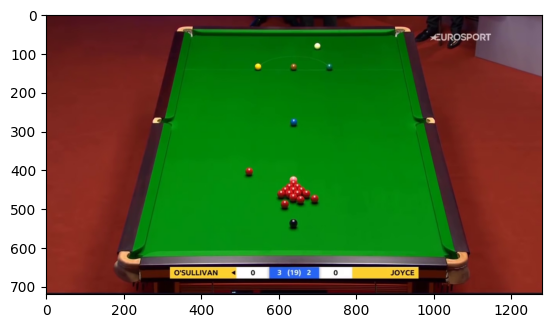

In [4]:
image_o = cv2.imread('./data/WSC sample.png')
image = image_o.copy()
show_bgr_image(image)

### Sanity check for HSI and BGR conversion functions

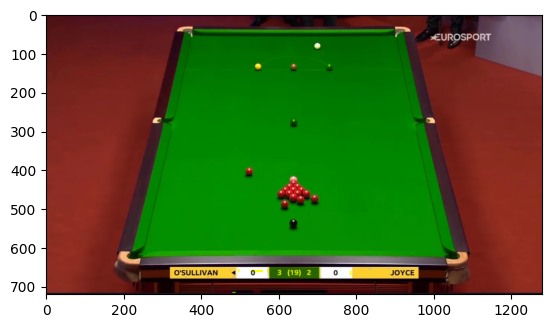

In [5]:
show_bgr_image(hsi_to_bgr(bgr_to_hsi(image)))

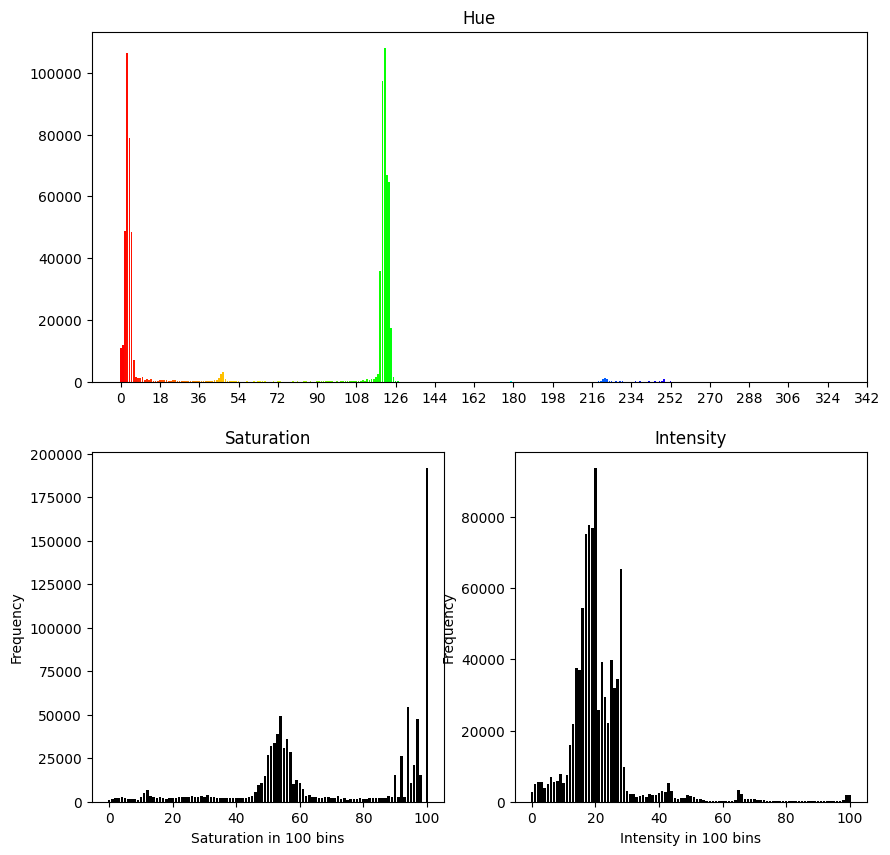

In [6]:
hsi_image = bgr_to_hsi(image)
hsi_freqs = get_hsi_frequencies(hsi_image)
plot_hsi_freq(hsi_freqs)

## We can see that values of hue between 100 and 130 provide a good threshold to filter out the top of the table

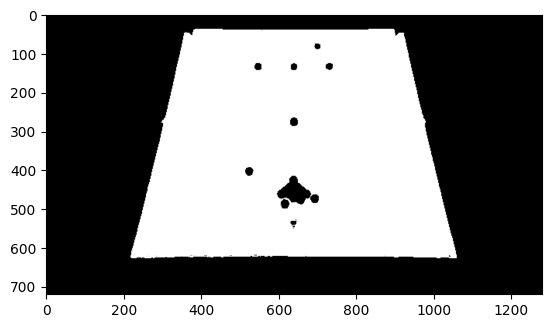

In [7]:
hue = hsi_image[...,0]
table = (hue > 100) & (hue < 130)
filtered = np.zeros_like(image)
filtered[table] = [255,255,255]
show_bgr_image(filtered)

## Getting some stats about the video

In [816]:
video = cv2.VideoCapture('./data/WSC.mp4')
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
frame_rate = video.get(cv2.CAP_PROP_FPS)
video_duration = frame_count / frame_rate
print(f"The video duration is {video_duration} seconds.")
# convert to hour, minutes seconds
video_duration = int(video_duration)
hours = video_duration // 3600
minutes = (video_duration % 3600) // 60
seconds = video_duration % 60
print(f"The video duration is {hours} hours, {minutes} minutes and {seconds} seconds.")
video.release()

The video duration is 12262.6 seconds.
The video duration is 3 hours, 24 minutes and 22 seconds.


In [9]:
interesting_frames_timestamps = {
    0: {'hour': 0, 'minute': 16, 'second': 56 },
    1: {'hour': 0, 'minute': 17, 'second': 31 },
    2: {'hour': 0, 'minute': 28, 'second': 40 },
    3: {'hour': 0, 'minute': 29, 'second': 8 },
    4: {'hour': 0, 'minute': 29, 'second': 39 },
    5: {'hour': 0, 'minute': 29, 'second': 42 },
    6: {'hour': 0, 'minute': 59, 'second': 18 },
    7: {'hour': 2, 'minute': 51, 'second': 40 },
    8: {'hour': 2, 'minute': 39, 'second': 27 },
    9: {'hour': 0, 'minute': 0, 'second': 0 },  
    10: {'hour': 0, 'minute': 13, 'second': 26 }   
}

video = cv2.VideoCapture('./data/WSC.mp4')
for i, timestamp in interesting_frames_timestamps.items():
    video.set(cv2.CAP_PROP_POS_MSEC, (timestamp['hour']*3600 + timestamp['minute']*60 + timestamp['second'])*1000)
    ret, frame = video.read()
    cv2.imwrite(f'./data/interesting_frames/{i}.png', frame)
video.release()

In [10]:
image_filtered = image.copy()
image_filtered[~table] = [0,0,0]

dist = {}
for i in range(9):
    test_frame = cv2.imread(f'./data/interesting_frames/{i}.png')
    test_frame[~table] = [0,0,0]
    bool, dist[i] = is_frame_close(get_gray_scale(image_filtered), get_gray_scale(test_frame))
    cv2.putText(test_frame, f"Error: {dist[i]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imwrite(f'./data/interesting_frames/{i}_filtered.png', test_frame)
    
for i,v in dist.items():
    print(f"Frame {i} -> distance {v}")
print(dist)

{0: 1.332555802951388, 1: 0.9002221549479167, 2: 2.7958595800781243, 3: 0.6331101085069442, 4: 14.877442995876734, 5: 1.8299508083767362, 6: 5.02634072265625, 7: 4.076061618923611, 8: 8.848121379123267}


## A good threshold seems to be 1.0, hence we filter the whole video using our mask with that difference threshold

In [11]:
video = cv2.VideoCapture('./data/WSC.mp4')
frame_width = int(video.get(3))
frame_height = int(video.get(4))
fps = video.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('./data/WSC_filtered.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
true_table = ~table
filtered_gray_image = get_gray_scale(image_filtered)
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)


for i in tqdm(range(int(frame_count))):
    ret, frame = video.read()
    if ret:
        test_frame = frame.copy()
        test_frame[true_table] = [0,0,0]
        test_frame = get_gray_scale(test_frame)
        cond, diff = is_frame_close(filtered_gray_image, test_frame, avg_threshold=1)
        if cond:
            out.write(frame)
    else:
        break
    
video.release()
out.release()

  0%|          | 0/367878 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Getting the frame suggested in the slides, in timestamp 2:11:52, and saving it.

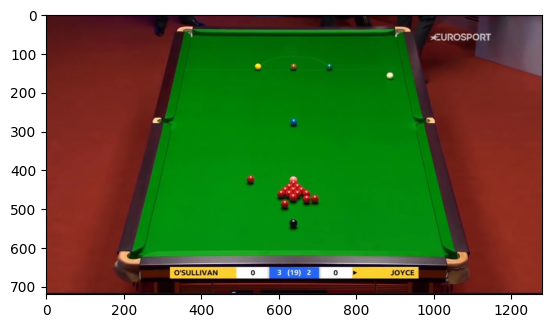

In [49]:
video = cv2.VideoCapture('./data/WSC.mp4')
video.set(cv2.CAP_PROP_POS_MSEC, (2*3600 + 11*60 + 52)*1000)
ret, frame = video.read()
cv2.imwrite(f'./data/balls_in_position.png', frame)
show_bgr_image(frame)

# 2. Camera Reconstruction

## Here we applied a custom version of grayscaling to bring out the contrast between the green and the brown of the table, which denote lines we are looking for

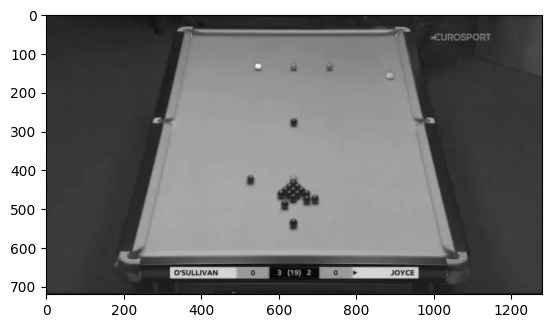

In [50]:
image_o = cv2.imread('./data/balls_in_position.png')
image = image_o.copy()
weights = np.array([-0.5, 1, 0])
gray_image = get_gray_scale(image, weights)
show_bgr_image(gray_image, grayscale=True)

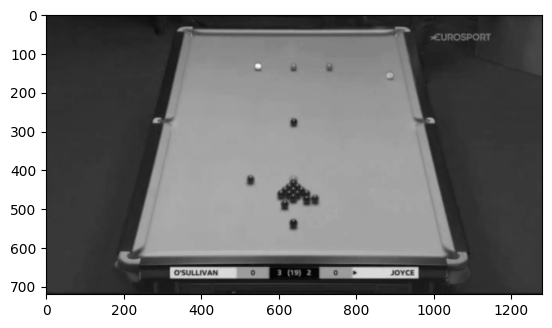

In [51]:
sigma=30
a=10
lowThresholdRatio=0.05
highThresholdRatio=0.09

gray_scale_img = apply_gaussian_filter(gray_image, sigma, a)
show_bgr_image(gray_scale_img, grayscale=True)

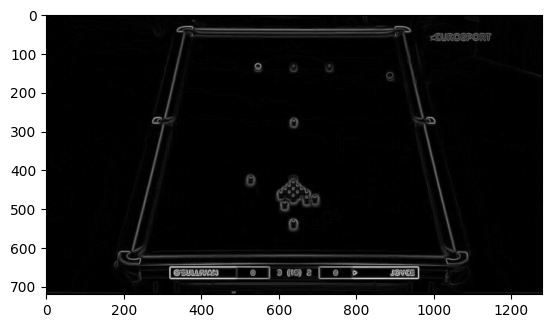

In [52]:
G, theta = sobel_operate(gray_scale_img)
show_bgr_image(G, grayscale=True)

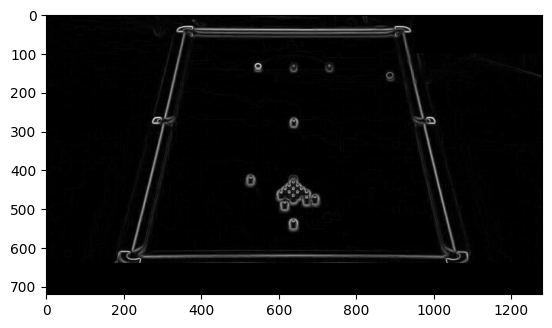

In [53]:
G[640:,:] = 0
G[0:100,950:] = 0
theta[640:,:] = 0
theta[0:100,950:] = 0
show_bgr_image(G, grayscale=True)

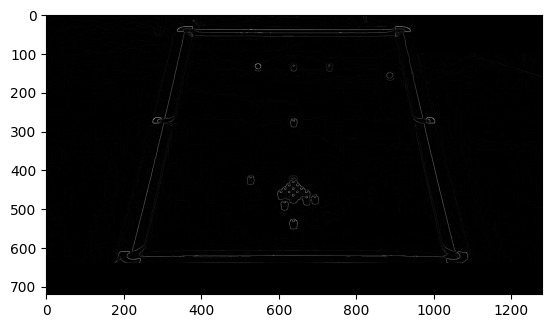

In [54]:
Z = non_max_suppression(G, theta)
show_bgr_image(Z, grayscale=True)

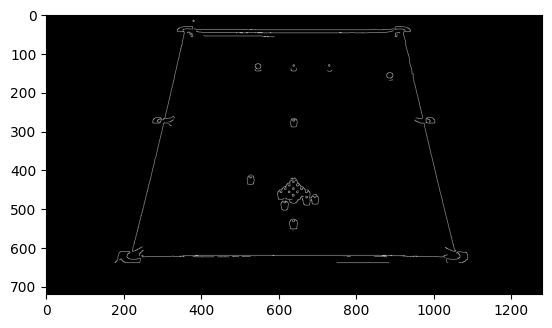

In [55]:
(res, weak, strong) = threshold(Z, 0.1, 0.30)
img_final = hysteresis(res, weak, strong)
show_bgr_image(img_final, grayscale=True)

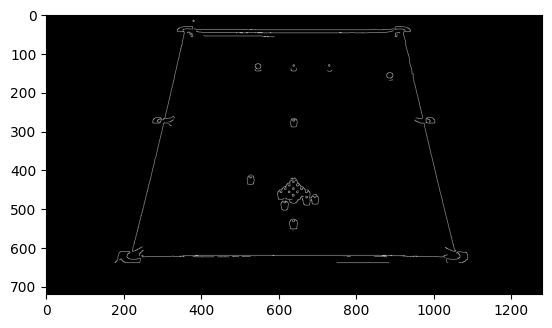

In [56]:
binary_image = binarized_thresholding(img_final, 50)
show_bgr_image(binary_image, grayscale=True)

In [ ]:
weights = np.array([-0.5, 1, 0])
gray_image = get_gray_scale(image, weights)
show_bgr_image(gray_image, grayscale=True)

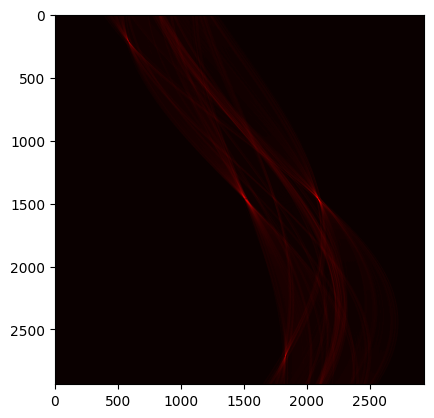

In [58]:
plt.imshow(space, cmap='hot')
plt.show()

In [59]:
with open('./data/hough_space.pkl', 'wb') as f:
    pickle.dump(space, f)

with open('./data/theta_map.pkl', 'wb') as f:
    pickle.dump(theta_map, f)

with open('./data/rho_map.pkl', 'wb') as f:
    pickle.dump(rho_map, f)

In [60]:
max_args = np.argwhere(space > 200)
print(len(max_args))

60


In [61]:
lines = []

for i,j in max_args:
    lines.append((i,j))

for i,line in enumerate(lines):
    save_path = f'./data/hough/hough_lines_{max_args[i][0]}_{max_args[i][1]}.png'
    plot_hough_lines(image, [line], theta_map, rho_map, save_path=save_path, indices=[max_args[i]])

In [62]:
lines = {
    'top':[1471,1510],
    'bottom':[1472,2092],
    'left':[2712, 1829],
    'right':[213, 581]
}

for k in lines.keys():
    lines[k] = [theta_map[lines[k][0]], rho_map[lines[k][1]]]
    

In [247]:
# find the intersection points between each pari of lines   

def find_intersection_point(line1, line2):
    t1, r1 = line1
    t2, r2 = line2
    A = np.array([[np.sin(t1), np.cos(t1)], [np.sin(t2), np.cos(t2)]])
    b = np.array([r1, r2])
    return np.linalg.solve(A, b)

top_left = find_intersection_point(lines['top'], lines['left'])
top_right = find_intersection_point(lines['top'], lines['right'])
bottom_left = find_intersection_point(lines['bottom'], lines['left'])
bottom_right = find_intersection_point(lines['bottom'], lines['right'])



In [118]:
print(f"Top left: {top_left}")
print(f"Top right: {top_right}")
print(f"Bottom left: {bottom_left}")
print(f"Bottom right: {bottom_right}")
print(f"Center Top: [132,638]")
print(f"Center ccenter: [271, 638]")

Top left: [361.64364174  40.64544018]
Top right: [919.50948027  38.55546268]
Bottom left: [219.94856423 622.94779295]
Bottom right: [1054.17207249  618.92951417]
Center Top: [132,638]
Center ccenter: [271, 638]


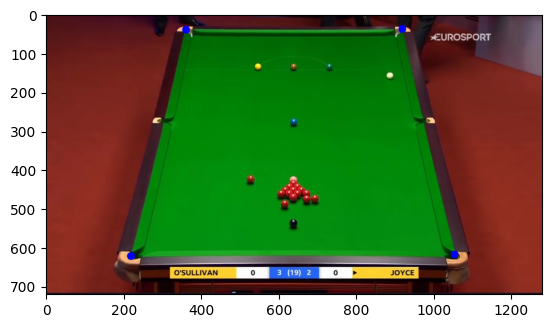

In [65]:
Gn = image.copy()
cv2.circle(Gn, (int(top_left[0]), int(top_left[1])), 10, (255, 0, 0), -1)
cv2.circle(Gn, (int(top_right[0]), int(top_right[1])), 10, (255, 0, 0), -1)
cv2.circle(Gn, (int(bottom_left[0]), int(bottom_left[1])), 10, (255, 0, 0), -1)
cv2.circle(Gn, (int(bottom_right[0]), int(bottom_right[1])), 10, (255, 0, 0), -1)
show_bgr_image(Gn)

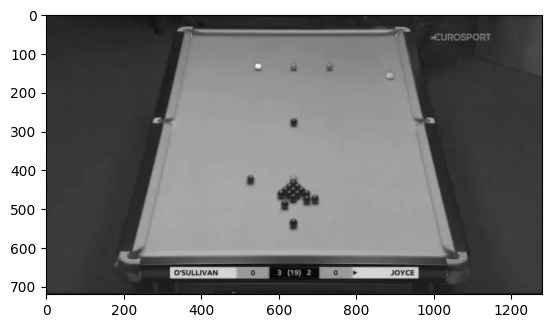

In [119]:
image_o = cv2.imread('./data/balls_in_position.png')
image = image_o.copy()
image[240:310,600:650,:]
image[0:240,600:650,:]


# Applying DLT

In [36]:
table_ratio = 3.569/1.778
img_width = 720
img_height = round(img_width * table_ratio)
print(f"Image width: {img_width}, Image height: {img_height}")

Image width: 720, Image height: 1445


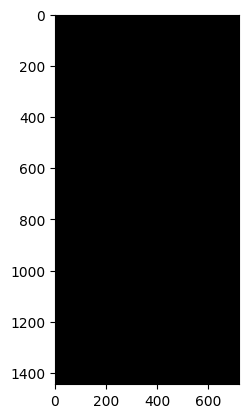

In [37]:
new_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
show_bgr_image(new_img)

In [43]:
3.569/1.778

2.0073115860517436

Image width: 720, Image height: 936


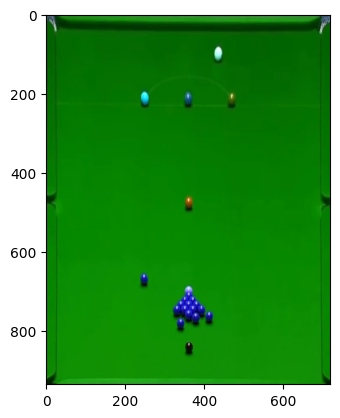

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#table_ratio = 3.569/1.778
table_ratio = 1.3
img_width = 720
img_height = round(img_width * table_ratio)
print(f"Image width: {img_width}, Image height: {img_height}")

# Function to construct the matrix A for DLT
def construct_A(pts_src, pts_dst):
    for i in range(len(pts_src)):
        X, Y, Z = pts_src[i][0], pts_src[i][1], pts_src[i][2]
        u, v = pts_dst[i][0], pts_dst[i][1]
        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, X*u, Y*u, Z*u, u])
        A.append([0, 0, 0, 0, -X, -Y, -Z, -1, X*v, Y*v, Z*v, v])
    return np.array(A)

# Function to compute homography using SVD
def compute_homography(A):
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 4)
    return H

# Function to warp perspective using the homography matrix
def warp_perspective(image, H, dst_size):
    H_pinv = np.linalg.pinv(H)  # Compute the Pseudo-Inverse
    dst_img = Image.new("RGB", dst_size) # modify to accommodate our implementation BGR
    width, height = dst_size
    
    for i in range(width):
        for j in range(height):
            src_pt = np.dot(H_pinv, [i, j, 0, 1])  # Add a zero for the Z coordinate
            src_pt /= src_pt[2]
            x, y = int(src_pt[0]), int(src_pt[1])
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                dst_img.putpixel((i, j), tuple(image[y, x]))
    
    return np.array(dst_img)

# Example coordinates of the corners in the image (replace with your actual coordinates)
pts_src = np.array([
    [top_left[0], top_left[1], 16],
    [top_right[0], top_right[1], 16],
    [bottom_right[0], bottom_right[1], 16],
    [bottom_left[0], bottom_left[1], 16],
    [638.5, 131.9, 17],
    [638.5, 271, 0]
])

# Dimensions of the pool table in the top view
width, height = img_width, img_height  # Example dimensions, adjust as necessary

# Coordinates of the corners in the top-down view
pts_dst = np.array([
    [0, 0],
    [width, 0],
    [width, height],
    [0, height]
])

# Construct the matrix A
A = construct_A(pts_src, pts_dst)

# Compute the homography matrix
H = compute_homography(A)

# Load the image using PIL (replace 'path_to_your_image.jpg' with the actual path)
#image = np.array(Image.open('path_to_your_image.jpg'))

# Apply the transformation
top_view = warp_perspective(image, H, (width, height))

# Display the result
plt.imshow(top_view)
plt.show()


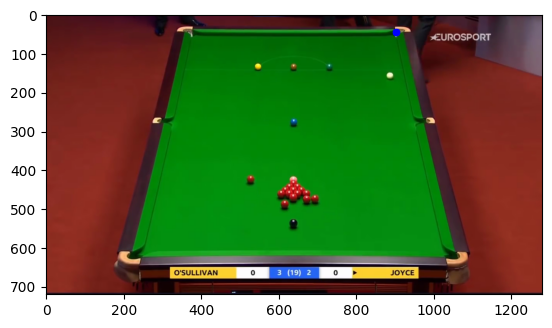

In [253]:
image_o = cv2.imread('./data/balls_in_position.png')
image = image_o.copy()

uv =  np.array([[253, 608], [1027, 608], [904,  47], [376,  47], [548, 143], [732, 143], [640, 143], [640, 287], [640, 437], [640, 549]])
uv =  np.array([[904,  47]])
#plot points in image and show
for i in range(uv.shape[0]):
    cv2.circle(image, (uv[i,0], uv[i,1]), 10, (255, 0, 0), -1)
show_bgr_image(image)

width of playable area = 1.778
length of playable area = 3.569
width of cushions = 0.0508
height of cushions = 0.0381
height of the ball = 0.0525
center to baulk line distance = 1.0475
baulk line ccenter (brown ball) to green or yellow distance = 0.292

In [251]:
print((3.569/2))
print((1.778/2))

1.7845
0.889


In [661]:
print((3.569/2)+0.0508)
print((1.778/2)+0.0508)

1.8353
0.9398


In [274]:
np.array([[1,2],[3,4]])

array([[1, 2],
       [3, 4]])

In [255]:
points_2d = np.array([
    [361.64364174, 40.64544018],  # top left
    [919.50948027, 38.55546268],  # top right
    [219.94856423, 622.94779295], # bottom left
    [1054.17207249, 618.92951417],# bottom right
    [641, 143],                # bottom brown ball
    [641, 287]                     # top blue ball
])



points_3d = np.array([
    [-0.9398, 1.8353, 0.0381],
    [0.9398, 1.8353, 0.0381],
    [-0.9398, -1.8353, 0.0381],
    [0.9398, -1.8353, 0.0381],
    [0, 1.0475, 0.0], 
    [0,0,0]
])

'''
xyz = np.array([[-0.889, -1.7845, 0.03], # bottom left
                [0.889, -1.7845, 0.03], # bottom right
                [0.889,  1.7845, 0.03], # top right
                  [-0.889,  1.7845, 0.03], # top left
                  [-0.292, 1.0475, 0], 
                  [0.292, 1.0475, 0],
                  [0, 1.0475, 0], 
                  [0, 0, 0], 
                  [0,-0.89225, 0], 
                  [0,-1.4605, 0]])

uv =  np.array([[253, 608], 
                [1027, 608], 
                [904,  47], 
                [376,  47], 
                [548, 143], 
                [732, 143], 
                [640, 143], 
                [640, 287], 
                [640, 437], 
                [640, 549]])
'''

In [276]:
def get_A(x,X):
  number_points = len(x)
  A = np.zeros(shape=(2*number_points, 12))

  for i in range(number_points):
    xi = x[i, 0] #x coordinate of the image point
    yi = x[i, 1] #y coordinate of the image point
    wi = 1 #w coordinate of the image point
    ai = np.concatenate(([0,0,0,0], -wi * X[i], yi * X[i]))
    bi = np.concatenate((wi * X[i],[0,0,0,0], -xi * X[i]))
    A[2*i] = ai
    A[2*i+1] = bi

  return A

def get_p(A):
    r = np.linalg.svd(A)
    V = r[2].T
    p_vector = V[:, -1]
    p_matrix = np.reshape(p_vector, (3, 4))

    return p_matrix

def get_camera_coordinates(p):
  """calculates the camera coordinates on the world coordinates system"""
  p1 = p[:,0]
  p2 = p[:,1]
  p3 = p[:,2]
  p4 = p[:,3]

  p1_column = p1.reshape(-1, 1)
  p2_column = p2.reshape(-1, 1)
  p3_column = p3.reshape(-1, 1)
  p4_column = p4.reshape(-1, 1)

  X = np.linalg.det(np.concatenate((p2_column, p3_column, p4_column), axis=1))
  Y = -np.linalg.det(np.concatenate((p1_column, p3_column, p4_column), axis=1))
  Z = np.linalg.det(np.concatenate((p1_column, p2_column, p4_column), axis=1))
  W = -np.linalg.det(np.concatenate((p1_column, p2_column, p3_column), axis=1))
  return np.array([X,Y,Z,W]) / W


def get_camera_coordinates(p):
  p1 = p[:,0]
  p2 = p[:,1]
  p3 = p[:,2]
  p4 = p[:,3]

  p1_column = p1.reshape(-1, 1)
  p2_column = p2.reshape(-1, 1)
  p3_column = p3.reshape(-1, 1)
  p4_column = p4.reshape(-1, 1)

  X = np.linalg.det(np.concatenate((p2_column, p3_column, p4_column), axis=1))
  Y = -np.linalg.det(np.concatenate((p1_column, p3_column, p4_column), axis=1))
  Z = np.linalg.det(np.concatenate((p1_column, p2_column, p4_column), axis=1))
  W = -np.linalg.det(np.concatenate((p1_column, p2_column, p3_column), axis=1))
  return np.array([X,Y,Z,W]) / W

def get_camera_calibration_camera_orientation(p):
    """ We require that the diagonal elements of R are positive such R and Q are unique. -> https://en.wikipedia.org/wiki/QR_decomposition
        Enforcing positive diagonal elements in R helps to maintain consistency in the estimation of the camera orientation matrix Q.
        If the signs of the diagonal elements in R were allowed to be negative,
        it would introduce ambiguity in the estimation of Q,
        as different combinations of R and Q could produce the same overall matrix M.
        By ensuring positive diagonal elements in R, we resolve this ambiguity and obtain a unique and consistent estimate of the camera orientation.
    """
    M = p[:,:3]
    pi = np.array([[0,0,1], [0,1,0], [1,0,0]])
    Q, R = np.linalg.qr(M.T @ pi)

    # ensuring a positive diagonal
    D = np.diag(np.sign(np.diag(R)))
    R = R @ D
    Q = Q @ D

    camera_calibration_matrix = pi @ R.T @ pi
    camera_orientation_matrix = pi @ Q.T

    return camera_calibration_matrix, camera_orientation_matrix #, R, pi, Q

In [278]:
x = np.array(points_2d).T
x = np.vstack((x, np.ones(x.shape[1]))).T
X = np.array(points_3d).T
X = np.vstack((X, np.ones(X.shape[1]))).T
A = get_A(x, X)
p = get_p(A)

camera_coordinates = get_camera_coordinates(p)
camera_calibration, camera_orientation = get_camera_calibration_camera_orientation(p)

In [279]:
camera_coordinates

array([-0.00881598,  0.0401118 ,  0.0381    ,  1.        ])

[-1.22620312e-01  1.99996241e+01 -1.42108547e-13]
[-1.99996241e+01 -1.22620312e-01  5.13762166e-12]
[-5.13668204e-12 -1.68751271e-13 -2.00000000e+01]


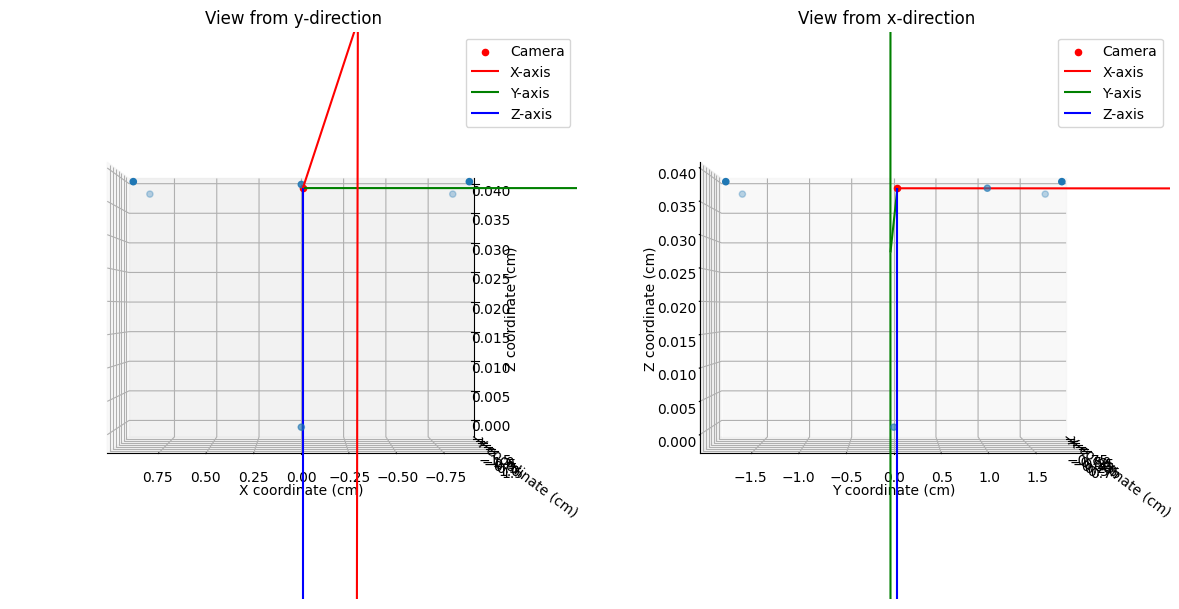

In [280]:
fig = plt.figure(figsize=(12, 6))
X = points_3d
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax1.scatter3D(camera_coordinates[0], camera_coordinates[1], camera_coordinates[2], color="r", label='Camera')
#  camera orientation axis
for i, color, label in zip(range(3), ['red', 'green', 'blue'], ['X', 'Y', 'Z']):
    axis = camera_orientation[:, i] * 20
    ax1.quiver(camera_coordinates[0], camera_coordinates[1], camera_coordinates[2],
               axis[0], axis[1], axis[2], color=color, label=f'{label}-axis')
ax1.set_xlabel('X coordinate (cm)')
ax1.set_ylabel('Y coordinate (cm)')
ax1.set_zlabel('Z coordinate (cm)')
ax1.set_title('View from y-direction')
ax1.grid(True)
ax1.view_init(elev=0, azim=90)
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax2.scatter3D(camera_coordinates[0], camera_coordinates[1], camera_coordinates[2], color="r", label='Camera')
#  camera orientation axis
for i, color, label in zip(range(3), ['red', 'green', 'blue'], ['X', 'Y', 'Z']):
    axis = camera_orientation[:, i] * 20
    print(axis)
    ax2.quiver(camera_coordinates[0], camera_coordinates[1], camera_coordinates[2],
               axis[0], axis[1], axis[2], color=color, label=f'{label}-axis')
ax2.set_xlabel('X coordinate (cm)')
ax2.set_ylabel('Y coordinate (cm)')
ax2.set_zlabel('Z coordinate (cm)')
ax2.set_title('View from x-direction')
ax2.grid(True)
ax2.view_init(elev=0, azim=0)
ax2.legend()

plt.tight_layout()
plt.show()

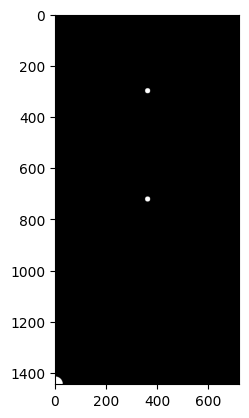

In [215]:
# create array of size int(aspect_ratio*720) by 720
img_temp = np.zeros((int(aspect_ratio*720), 720, 3), dtype=np.uint8)
# create a circle in coordinates [int(720*(0.74/1.778)), 360], [int(aspect_ratio*720/2), 360]
cv2.circle(img_temp, (360,int(720*(0.74/1.778))), 10, (255, 255, 255), -1)
cv2.circle(img_temp, (360,int(aspect_ratio*720/2)), 10, (255, 255, 255), -1)
cv2.circle(img_temp, (0,int(aspect_ratio*720)), 30, (255, 255, 255), -1)
show_bgr_image(img_temp)

In [216]:
image.shape

(720, 1280, 3)

In [256]:
import numpy as np

def Normalization(nd, x):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).

    Input
    -----
    nd: number of dimensions, 3 here
    x: the data to be normalized (directions at different columns and points at rows)
    Output
    ------
    Tr: the transformation matrix (translation plus scaling)
    x: the transformed data
    '''

    x = np.asarray(x)
    m, s = np.mean(x, 0), np.std(x)
    if nd == 2:
        Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    else:
        Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])
        
    Tr = np.linalg.inv(Tr)
    x = np.dot( Tr, np.concatenate( (x.T, np.ones((1,x.shape[0]))) ) )
    x = x[0:nd, :].T

    return Tr, x


def DLTcalib(nd, xyz, uv):
    '''
    Camera calibration by DLT using known object points and their image points.

    Input
    -----
    nd: dimensions of the object space, 3 here.
    xyz: coordinates in the object 3D space.
    uv: coordinates in the image 2D space.

    The coordinates (x,y,z and u,v) are given as columns and the different points as rows.

    There must be at least 6 calibration points for the 3D DLT.

    Output
    ------
     L: array of 11 parameters of the calibration matrix.
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
    '''
    if (nd != 3):
        raise ValueError('%dD DLT unsupported.' %(nd))
    
    # Converting all variables to numpy array
    xyz = np.asarray(xyz)
    uv = np.asarray(uv)

    n = xyz.shape[0]

    # Validating the parameters:
    if uv.shape[0] != n:
        raise ValueError('Object (%d points) and image (%d points) have different number of points.' %(n, uv.shape[0]))

    if (xyz.shape[1] != 3):
        raise ValueError('Incorrect number of coordinates (%d) for %dD DLT (it should be %d).' %(xyz.shape[1],nd,nd))

    if (n < 6):
        raise ValueError('%dD DLT requires at least %d calibration points. Only %d points were entered.' %(nd, 2*nd, n))
        
    # Normalize the data to improve the DLT quality (DLT is dependent of the system of coordinates).
    # This is relevant when there is a considerable perspective distortion.
    # Normalization: mean position at origin and mean distance equals to 1 at each direction.
    Txyz, xyzn = Normalization(nd, xyz)
    Tuv, uvn = Normalization(2, uv)

    A = []

    for i in range(n):
        x, y, z = xyzn[i, 0], xyzn[i, 1], xyzn[i, 2]
        u, v = uvn[i, 0], uvn[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )

    # Convert A to array
    A = np.asarray(A) 

    # Find the 11 parameters:
    U, S, V = np.linalg.svd(A)

    # The parameters are in the last line of Vh and normalize them
    L = V[-1, :] / V[-1, -1]
    print(L.shape)
    # Camera projection matrix
    H = L.reshape(3, nd + 1)
    print(H)

    # Denormalization
    # pinv: Moore-Penrose pseudo-inverse of a matrix, generalized inverse of a matrix using its SVD
    H = np.dot( np.dot( np.linalg.pinv(Tuv), H ), Txyz )
    print(H)
    H = H / H[-1, -1]
    print(H)
    '''
    L = H.flatten('C')
    print(L)

    # Mean error of the DLT (mean residual of the DLT transformation in units of camera coordinates):
    uv2 = np.dot( H, np.concatenate( (xyz.T, np.ones((1, xyz.shape[0]))) ) ) 
    uv2 = uv2 / uv2[2, :] 
    # Mean distance:
    err = np.sqrt( np.mean(np.sum( (uv2[0:2, :].T - uv)**2, 1)) ) 

    return L, err
    '''
    return H

def DLT(xyz, uv):
    nd = 3
    return  DLTcalib(nd, xyz, uv)

In [258]:
H = DLT(points_3d, points_2d)

(12,)
[[-0.00000000e+00 -5.87815848e-14  7.74409652e+00 -5.07225328e-02]
 [ 1.39198619e-13 -2.40909389e-16  1.00676574e-01 -6.59414669e-04]
 [ 4.17976920e-15  1.52288050e-14 -1.52675667e+02  1.00000000e+00]]
[[ 1.23876599e-12 -1.50063970e-11 -4.26771654e+04  1.62600000e+03]
 [ 4.89778079e-11  9.95292510e-12 -1.00551181e+05  3.83100000e+03]
 [ 4.31130503e-15  1.57080500e-14 -1.57480315e+02  6.00000000e+00]]
[[ 2.06460998e-13 -2.50106616e-12 -7.11286089e+03  2.71000000e+02]
 [ 8.16296798e-12  1.65882085e-12 -1.67585302e+04  6.38500000e+02]
 [ 7.18550838e-16  2.61800833e-15 -2.62467192e+01  1.00000000e+00]]


In [259]:
H.shape

(3, 4)

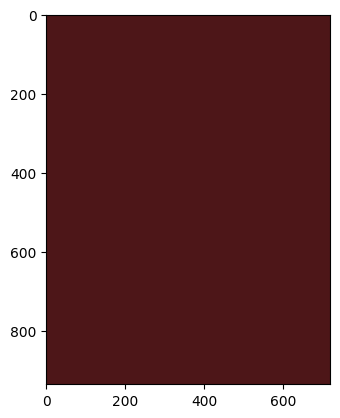

In [260]:
def warp_perspective(image, H, dst_size):
    H_inv = np.linalg.pinv(H)  # Using pseudo-inverse to handle 4x3 matrix
    dst_img = Image.new("RGB", dst_size)
    width, height = dst_size
    
    for i in range(width):
        for j in range(height):
            src_pt = np.dot(H_inv, [i, j,  1])  # 4-element point vector
            src_pt /= src_pt[2]  # Normalize by the third coordinate
            x, y = int(src_pt[0]), int(src_pt[1])
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                dst_img.putpixel((i, j), tuple(image[y, x]))
    
    return np.array(dst_img)

top_view = warp_perspective(image, H, (width, height))
show_bgr_image(top_view)

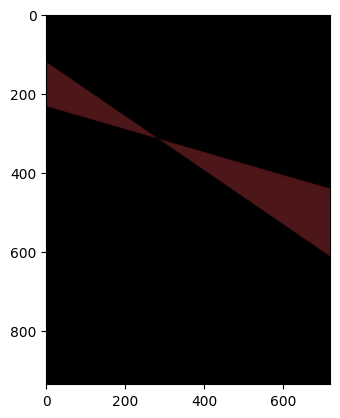

In [148]:
def warp_perspective_4x3(image, H, dst_size):
    # Adding the fourth row to H to make it 4x4 for homogeneous coordinates transformation
    H_augmented = np.vstack([H, [0, 0, 1]])  # Adding [0, 0, 1] to make it 4x4
    
    # Compute the inverse of the augmented homography matrix
    H_inv = np.linalg.inv(H_augmented)
    
    dst_img = Image.new("RGB", dst_size)
    width, height = dst_size
    
    for i in range(width):
        for j in range(height):
            src_pt = np.dot(H_inv, [i, j, 1])  # Homogeneous coordinates
            src_pt /= src_pt[3]  # Normalize using the depth (w) coordinate
            x, y = int(src_pt[0]), int(src_pt[1])
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                dst_img.putpixel((i, j), tuple(image[y, x]))
    
    return np.array(dst_img)

top_view = warp_perspective_4x3(image, H, (width, height))

show_bgr_image(top_view)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 3

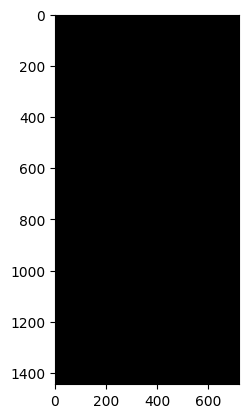

In [233]:
import numpy as np

def compute_homography_3D_to_2D(src_points, dst_points):
    # Check that the lists of points are the same length
    assert len(src_points) == len(dst_points)

    # Create matrix A
    A = []
    for i in range(len(src_points)):
        X, Y, Z = src_points[i]
        x, y = dst_points[i]
        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, x*X, x*Y, x*Z, x])
        A.append([0, 0, 0, 0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y])

    # Convert A to a numpy array
    A = np.array(A)

    # Compute the SVD of A
    _, _, V = np.linalg.svd(A)

    # The last column of V contains the solution
    H = V[-1].reshape((3, 4))

    return H

def warp_perspective_3D_to_2D(image, H, dst_size):
    # Augment H to make it 4x4
    H_augmented = np.vstack([H, [0, 0, 0, 1]])

    # Compute the inverse of the augmented homography matrix
    H_inv = np.linalg.inv(H_augmented)

    # Create a blank image to store the warped image
    dst_img = Image.new("RGB", dst_size)
    width, height = dst_size

    for i in range(width):
        for j in range(height):
            # Transform the point using the inverse homography matrix
            src_pt = np.dot(H_inv, [i, j, 0, 1])
            src_pt /= src_pt[3]  # Normalize by the fourth coordinate
            x, y = int(src_pt[0]), int(src_pt[1])

            # Check if the transformed point is within the bounds of the original image
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                dst_img.putpixel((i, j), tuple(image[y, x]))

    return np.array(dst_img)

aspect_ratio = 3.569/1.778
src_points = [[40.64544018,361.64364174,16],[38.55546268,919.50948027,16],[622.94779295,219.94856423,19],[618.92951417,1054.17207249,19],[131.9,638.5,17],[271,638.5,0]]
dst_points = [
    [0, 0],
    [0, 720],
    [int(aspect_ratio * 720), 0],
    [int(aspect_ratio * 720), 720],
    [int(720 * (0.74 / 1.778)), 360],
    [int(aspect_ratio * 720 / 2), 360]
]

image = image_o.copy()
H = compute_homography_3D_to_2D(src_points, dst_points)
show_bgr_image(image)
top_view = warp_perspective_3D_to_2D(image, H, (720,int(aspect_ratio*720)))
show_bgr_image(top_view)

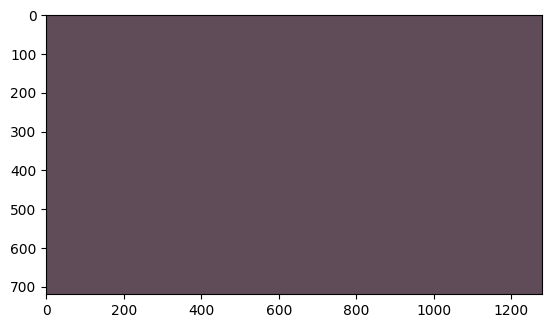

In [262]:

def dlt_3d_to_2d(points_3d, points_2d):
    assert len(points_3d) == len(points_2d) == 6, "There must be exactly 6 points for both 3D and 2D inputs."
    
    # Construct matrix A
    A = []
    for i in range(len(points_3d)):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
    
    A = np.array(A)
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(A)
    L = Vt[-1, :] / Vt[-1, -1]  # Normalize
    
    # Reshape the solution to get the homography matrix
    H = L.reshape(3, 4)
    
    return H

def apply_homography_to_image(H, image):
    height, width, _ = image.shape
    transformed_image = np.zeros_like(image)
    
    # Generate grid of pixel coordinates in the source image
    y, x = np.indices((height, width))
    homogeneous_coords = np.stack([x.ravel(), y.ravel(), np.ones_like(x.ravel()), np.ones_like(x.ravel())])  # Add a row of ones
    
    # Apply homography
    transformed_coords = H @ homogeneous_coords
    transformed_coords /= transformed_coords[2, :]  # Normalize by z
    
    x_transformed = transformed_coords[0, :].reshape(height, width).astype(int)
    y_transformed = transformed_coords[1, :].reshape(height, width).astype(int)
    
    # Ensure the coordinates are within image bounds
    x_transformed = np.clip(x_transformed, 0, width - 1)
    y_transformed = np.clip(y_transformed, 0, height - 1)
    
    # Map the transformed coordinates to the original image
    transformed_image[y, x] = image[y_transformed, x_transformed]
    
    return transformed_image

aspect_ratio = 3.569/1.778
src_points = [[40.64544018,361.64364174,16],[38.55546268,919.50948027,16],[622.94779295,219.94856423,19],[618.92951417,1054.17207249,19],[131.9,638.5,17],[271,638.5,0]]
dst_points = [[0,0],[0,720],[int(aspect_ratio * 720), 0],[int(aspect_ratio * 720), 720],[int(720 * (0.74 / 1.778)), 360],[int(aspect_ratio * 720 / 2), 360]]
src_points = [[y, x, z] for x, y, z in src_points]
dst_points = [[y, x] for x, y in dst_points]

image = image_o.copy()
H = dlt_3d_to_2d(points_3d, points_2d)
show_bgr_image(image)
top_view = apply_homography_to_image(H, image)
show_bgr_image(top_view)


# getting white dots on balls

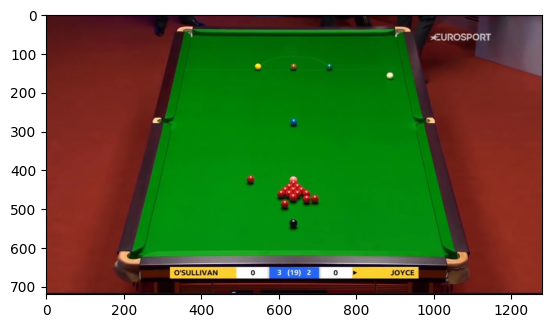

In [35]:
image_o = cv2.imread('./data/balls_in_position.png')
image = image_o.copy()
show_bgr_image(image)

In [81]:
theta_map = pickle.load(open('./data/theta_map.pkl', 'rb'))
rho_map = pickle.load(open('./data/rho_map.pkl', 'rb'))

lines = {
    'top':[1471,1510],
    'bottom':[1472,2092],
    'left':[2712, 1829],
    'right':[213, 581]
}

for k in lines.keys():
    lines[k] = [theta_map[lines[k][0]], rho_map[lines[k][1]]]


#image = cv2.imread('./data/WSC sample.png')

image = cv2.imread('./interesting_frame_0.png')

a = lambda x,y: x>y
b = lambda x,y: x<y
l = [a,b,a,b]

mask = np.ones_like(image[...,0]) 

for i,line in enumerate(lines.values()):
    theta, rho = line
    a = np.sin(theta)
    b = np.cos(theta)
    x = lambda y: -b*y/a + rho/a

    for xi in range(image.shape[1]):
        for yi in range(image.shape[0]):
            if l[i](x(yi), xi):
                mask[yi,xi] = 0


image2 = image.copy()
mask2 = mask.copy()

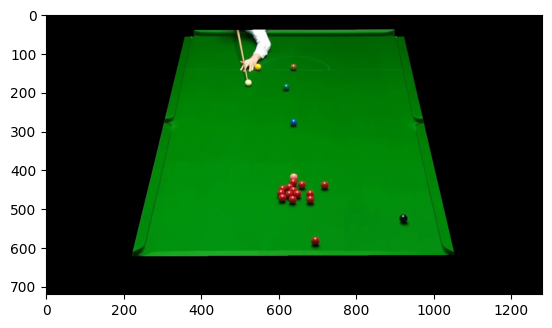

In [82]:
image = image2.copy()
mask = mask2.copy()
i = 33
j = 356
mask[i:i+25,j:j+25] = 0
image[mask == 0] = [0,0,0]
i = 33
j = 900
mask[i:i+25,j:j+25] = 0
image[mask == 0] = [0,0,0]
show_bgr_image(image)

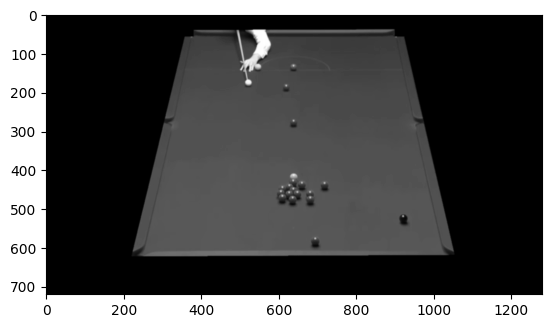

In [93]:
img = image.copy()
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
show_bgr_image(gray_image, grayscale=True)

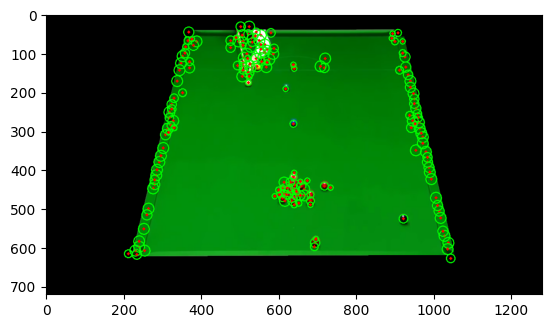

In [134]:
# compute hough circle space on image
img2= img.copy()
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, 1, 10, param1=30, param2=5, minRadius=6, maxRadius=15)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    cv2.circle(img2, (i[0], i[1]), i[2], (0, 255, 0), 2)
    cv2.circle(img2, (i[0], i[1]), 2, (0, 0, 255), 3)
show_bgr_image(img2)

None


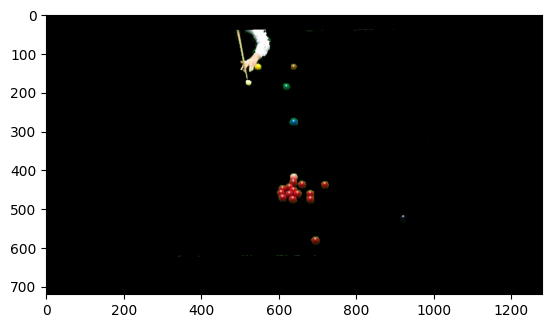

In [69]:
hsi_image = bgr_to_hsi(image)
hue = hsi_image[...,0]
table = (hue > 90) & (hue < 130)
mask[table] = 0
image[mask == 0] = [0,0,0]
show_bgr_image(image)

In [70]:
filters = pickle.load(open('./study/filters.pkl', 'rb'))

hsi_image = bgr_to_hsi(image)

def is_in_filter(h,s,i,l,u):
    cond1 = l[0] <= h <= u[0]
    cond2 = l[1] <= s <= u[1]
    cond3 = l[2] <= i <= u[2]
    return cond1 and cond2 and cond3

for i in range(hsi_image.shape[0]):
    for j in range(hsi_image.shape[1]):
        if mask[i,j] == 0:
                continue
        found = False
        for f in filters:   
            if is_in_filter(*hsi_image[i,j], *f):
                found = True
            if found == True:
                break
        if found == False:
            mask[i,j] = 0  
   


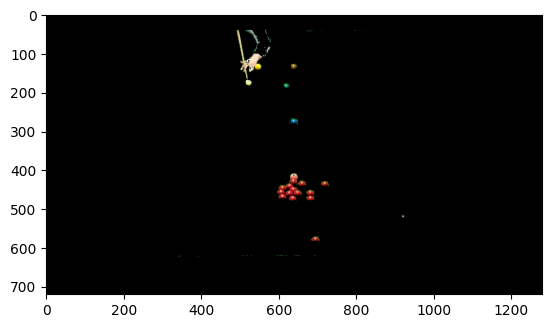

In [72]:
image[mask == 0] = [0,0,0]
show_bgr_image(image)

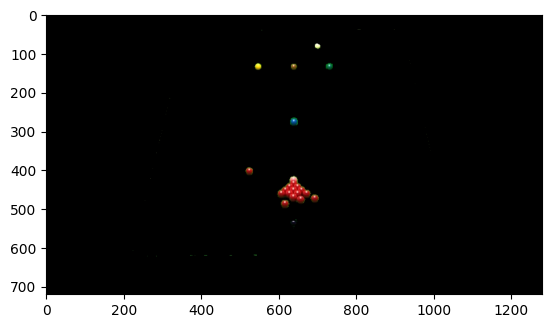

In [38]:
table = (hue > 90) & (hue < 130)
mask[table] = 0
image[mask == 0] = [0,0,0]
show_bgr_image(image)

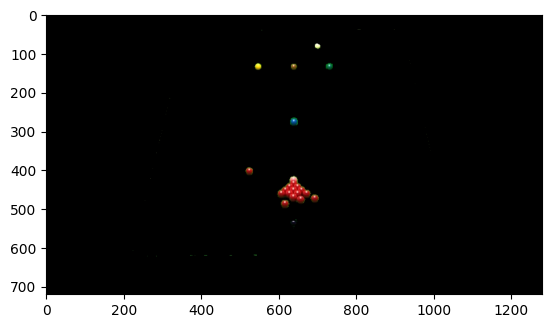

In [39]:
hsi_image = bgr_to_hsi(image)
hue = hsi_image[...,0]
table = (hue > 90) & (hue < 130)
mask[table] = 0
image[mask == 0] = [0,0,0]
show_bgr_image(image)

save3 = mask.copy(),image.copy()

In [73]:
save3 = mask.copy(),image.copy()

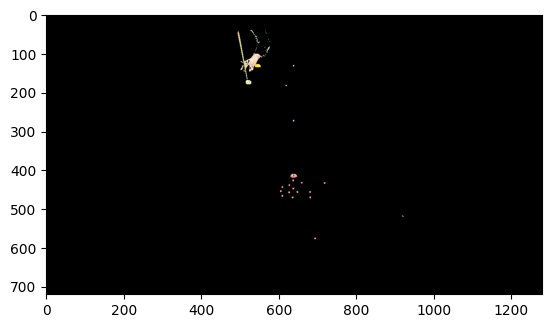

In [74]:
mask, image = save3[0].copy(), save3[1].copy()
intensity = hsi_image[...,2]
table = intensity < 0.6
mask[table] = 0
image[mask == 0] = [0,0,0]
show_bgr_image(image)

In [75]:
def get_components(mask):
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    components = []

    def dfs(row, col):
        stack = [(row, col)]
        component = []

        while stack:
            curr_row, curr_col = stack.pop()
            if curr_row < 0 or curr_row >= rows or curr_col < 0 or curr_col >= cols or visited[curr_row, curr_col]:
                continue

            visited[curr_row, curr_col] = True
            component.append((curr_row, curr_col))

            neighbors = [(curr_row + 1, curr_col), (curr_row - 1, curr_col),
                            (curr_row, curr_col + 1), (curr_row, curr_col - 1)]
            for neighbor in neighbors:
                if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and mask[neighbor]:
                    stack.append(neighbor)

        return component

    for pixel in np.argwhere(mask):
        if not visited[tuple(pixel)]:
            component = dfs(pixel[0], pixel[1])
            components.append(component)

    return components

components = get_components(mask)
for c in components:
    print(len(c))

2
102
1436
2
1
2
1
1
2
2
1
1
1
55
4
3
3
2
1
2
1
4
7
3
1
1
15
1
47
15
12
138
13
18
133
18
16
18
17
16
20
20
20
19
21
20
20
20
12
19


In [78]:
comp = components.copy()
comp = [c for c in comp if len(c) > 6 and len(c)<150]

avg_points = []
for c in comp:
    c = np.array(c)
    avg_points.append(np.mean(c, axis=0))

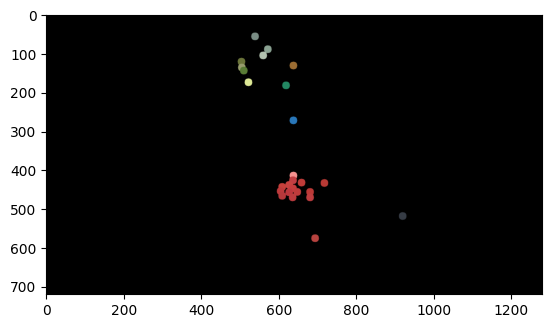

In [79]:
result = np.zeros_like(image2)
img = image2.copy()

for i,p in enumerate(avg_points):
    # sample a region around the point
    x,y = int(p[1]), int(p[0])
    region = img[y:y+7,x-4:x+5]
    # average the rgb of the region
    avg_color = np.mean(region, axis=(0,1))
    #cv2.imwrite(f'./study/ball_{i}.png', region)
    # fill the region with the average color
    # draw a circle around the point
    cv2.circle(result, (x,y), 10, avg_color, -1)

show_bgr_image(result)


    

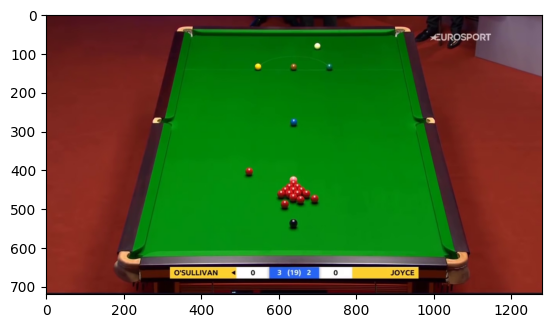

In [47]:
img = image2.copy()
show_bgr_image(img)

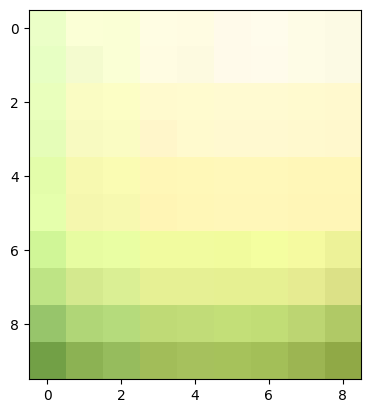

In [56]:

p=avg_points[0]
x,y = int(p[1]), int(p[0])
region = img[y-3:y+7,x-4:x+5]
cv2.imwrite(f'./study/ball_{0}.png', region)
show_bgr_image(region)

In [63]:
filters = []

for i in range(len(avg_points)):
    img = cv2.imread(f'./study/ball_{i}.png')
    hsi_image = bgr_to_hsi(img)
    h = hsi_image[...,0]
    s = hsi_image[...,1]
    i = hsi_image[...,2]
    lower_bounds = (np.min(h), np.min(s), np.min(i))
    upper_bounds = (np.max(h), np.max(s), np.max(i))
    filters.append((lower_bounds, upper_bounds))


In [64]:
pickle.dump(filters, open('./study/filters.pkl', 'wb'))

In [374]:
show_bgr_image(balls)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [371]:
for c in components:
    hsi

IndexError: index 907 is out of bounds for axis 0 with size 720

In [488]:
def compute_pre_mask(theta_map=None, rho_map=None):
    if theta_map is None:
        theta_map = pickle.load(open('./data/theta_map.pkl', 'rb'))
    if rho_map is None:
        rho_map = pickle.load(open('./data/rho_map.pkl', 'rb'))

    lines = {
        'top':[1471,1510],
        'bottom':[1472,2092],
        'left':[2712, 1829],
        'right':[213, 581]
    }

    for k in lines.keys():
        lines[k] = [theta_map[lines[k][0]], rho_map[lines[k][1]]]


    image = cv2.imread('./data/balls_in_position.png')

    a = lambda x,y: x>y
    b = lambda x,y: x<y
    l = [a,b,a,b]

    mask = np.ones_like(image[...,0]) 

    for i,line in enumerate(lines.values()):
        theta, rho = line
        a = np.sin(theta)
        b = np.cos(theta)
        x = lambda y: -b*y/a + rho/a

        for xi in range(image.shape[1]):
            for yi in range(image.shape[0]):
                if l[i](x(yi), xi):
                    mask[yi,xi] = 0
    i,j = 33,356
    mask[i:i+25,j:j+25] = 0
    i,j = 33,900
    mask[i:i+25,j:j+25] = 0

    return mask

In [489]:
def get_components(mask):
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    components = []

    def dfs(row, col):
        stack = [(row, col)]
        component = []

        while stack:
            curr_row, curr_col = stack.pop()
            if curr_row < 0 or curr_row >= rows or curr_col < 0 or curr_col >= cols or visited[curr_row, curr_col]:
                continue

            visited[curr_row, curr_col] = True
            component.append((curr_row, curr_col))

            neighbors = [(curr_row + 1, curr_col), (curr_row - 1, curr_col),
                            (curr_row, curr_col + 1), (curr_row, curr_col - 1)]
            for neighbor in neighbors:
                if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and mask[neighbor]:
                    stack.append(neighbor)

        return component

    for pixel in np.argwhere(mask):
        if not visited[tuple(pixel)]:
            component = dfs(pixel[0], pixel[1])
            components.append(component)

    return components

def get_balls_position_and_color(image, pre_mask, intensity_threshold=0.6, component_threshold=6):
    img = image.copy()
    mask = pre_mask.copy()
    img[mask == 0] = [0,0,0]
    hsi_image = bgr_to_hsi(img)

    hue = hsi_image[...,0]
    table = (hue > 90) & (hue < 130)

    mask[table] = 0
    img[mask == 0] = [0,0,0]
    sample_img = img.copy()

    intensity = hsi_image[...,2]
    table = intensity < intensity_threshold
    mask[table] = 0
    img[mask == 0] = [0,0,0]
    
    components = [c for c in get_components(mask) if len(c) > component_threshold]
    if len(components) > 22:
        # get the 22 largest components
        components = sorted(components, key=lambda x: len(x), reverse=True)[:22]
    
    avg_points = []
    for c in components:
        c = np.array(c)
        avg_points.append(np.mean(c, axis=0))

    result = []

    for p in avg_points:
        # sample a region around the point
        x,y = int(p[1]), int(p[0])
        region = sample_img[y-4:y+7,x-4:x+6]
        avg_color = np.mean(region, axis=(0,1))
        result.append((p, avg_color))
    
    return result

In [ ]:
def compute_pre_mask(theta_map=None, rho_map=None):
    if theta_map is None:
        theta_map = pickle.load(open('./data/theta_map.pkl', 'rb'))
    if rho_map is None:
        rho_map = pickle.load(open('./data/rho_map.pkl', 'rb'))

    lines = {
        'top':[1471,1510],
        'bottom':[1472,2092],
        'left':[2712, 1829],
        'right':[213, 581]
    }

    for k in lines.keys():
        lines[k] = [theta_map[lines[k][0]], rho_map[lines[k][1]]]


    image = cv2.imread('./data/balls_in_position.png')

    a = lambda x,y: x>y
    b = lambda x,y: x<y
    l = [a,b,a,b]

    mask = np.ones_like(image[...,0]) 

    for i,line in enumerate(lines.values()):
        theta, rho = line
        a = np.sin(theta)
        b = np.cos(theta)
        x = lambda y: -b*y/a + rho/a

        for xi in range(image.shape[1]):
            for yi in range(image.shape[0]):
                if l[i](x(yi), xi):
                    mask[yi,xi] = 0
    i,j = 33,356
    mask[i:i+25,j:j+25] = 0
    i,j = 33,900
    mask[i:i+25,j:j+25] = 0

    return mask

def get_components(mask):
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    components = []

    def dfs(row, col):
        stack = [(row, col)]
        component = []

        while stack:
            curr_row, curr_col = stack.pop()
            if curr_row < 0 or curr_row >= rows or curr_col < 0 or curr_col >= cols or visited[curr_row, curr_col]:
                continue

            visited[curr_row, curr_col] = True
            component.append((curr_row, curr_col))

            neighbors = [(curr_row + 1, curr_col), (curr_row - 1, curr_col),
                            (curr_row, curr_col + 1), (curr_row, curr_col - 1)]
            for neighbor in neighbors:
                if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and mask[neighbor]:
                    stack.append(neighbor)

        return component

    for pixel in np.argwhere(mask):
        if not visited[tuple(pixel)]:
            component = dfs(pixel[0], pixel[1])
            components.append(component)

    return components

def get_balls_position_and_color(image, pre_mask, intensity_threshold=0.6, component_threshold=(6,200)):
    img = image.copy()
    mask = pre_mask.copy()
    img[mask == 0] = [0,0,0]
    hsi_image = bgr_to_hsi(img)

    hue = hsi_image[...,0]
    table = (hue > 90) & (hue < 130)

    mask[table] = 0
    img[mask == 0] = [0,0,0]
    sample_img = img.copy()

    intensity = hsi_image[...,2]
    table = intensity < intensity_threshold
    mask[table] = 0
    img[mask == 0] = [0,0,0]
    
    components = [c for c in get_components(mask) if len(c) > component_threshold[0] and len(c) < component_threshold[1]]
    if len(components) > 22:
        # get the 22 largest components
        components = sorted(components, key=lambda x: len(x), reverse=True)[:22]
    
    avg_points = []
    for c in components:
        c = np.array(c)
        avg_points.append(np.mean(c, axis=0))

    result = []

    for p in avg_points:
        # sample a region around the point
        x,y = int(p[1]), int(p[0])
        region = sample_img[y-4:y+7,x-4:x+6]
        avg_color = np.mean(region, axis=(0,1))
        result.append((p, avg_color))
    
    return result

def find_intersection(X_0, X_1, quota):
    t = (quota - X_0[2]) / (X_1[2] - X_0[2])
    p = X_0 + t * (X_1 - X_0)
    return p

def get_3d_point_at_quota_given_2d(H_nullspace, x, quota):
    X = np.linalg.lstsq(H, x, rcond=None)[0]
    H_nullspace = H_nullspace.reshape(4)
    X_0 = X / X[-1]
    X_0 = X_0[:-1]
    X_1 = X + H_nullspace
    X_1 = X_1 / X_1[-1]
    X_1 = X_1[:-1]
    return find_intersection(X_0, X_1, quota)

22


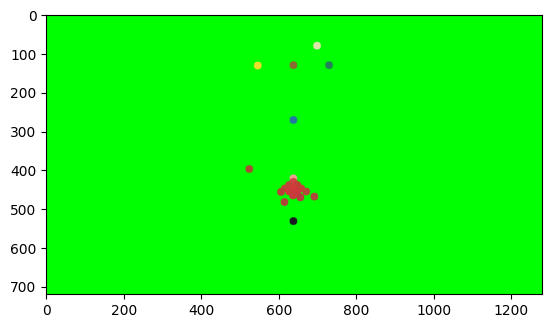

In [494]:
pre_mask = compute_pre_mask()
img = cv2.imread('./data/WSC sample.png')
bpos_color = get_balls_position_and_color(img, pre_mask, intensity_threshold=0.55, component_threshold=6)

# create an image like img full of green
plot_img = np.zeros_like(img)
plot_img[:] = (0, 255, 0)

for i, (pos, color) in enumerate(bpos_color):
    x, y = int(pos[1]), int(pos[0])
    cv2.circle(plot_img, (x, y), 10, color, -1)

print(len(bpos_color))
show_bgr_image(plot_img)

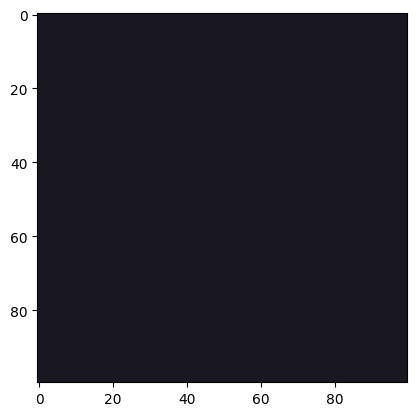

In [718]:
# plot this color in a small image
plot_color = np.zeros((100, 100, 3), dtype=np.uint8)
plot_color[:] = bpos_color[-1][1]
show_bgr_image(plot_color)
# this is yellow ball


In [721]:
bpos_color[-1][0]

array([532.375, 638.25 ])

# computing ball positions

In [516]:
import numpy as np
from scipy.linalg import null_space

def find_solution(P, x):
    # Solve for a particular solution using numpy's least squares method
    particular_solution = np.linalg.lstsq(P, x, rcond=None)[0]

    # Compute the null space of the projection matrix P
    nullspace = null_space(P)

    return particular_solution, nullspace

H = np.array([[ 3.51223119e+02,  6.74129774e+01, -1.07236520e+02, 6.40000000e+02],
              [ 2.02016484e-13, -1.21945201e+02, -4.52236941e+02, 2.86689753e+02],
              [ 3.09723597e-13,  1.05332777e-01, -1.67557063e-01, 1.00000000e+00]])

x = np.array([548, 143, 1])

particular_solution, nullspace = find_solution(H, x)
particular_solution = particular_solution / particular_solution[-1]
print("Particular solution:", particular_solution)
nullspace = nullspace / nullspace[-1]
print("Null space:", nullspace)


Particular solution: [-0.25816617  0.26301778  0.2513664   1.        ]
Null space: [[-7.60490840e-12]
 [-5.93816686e+00]
 [ 2.23515731e+00]
 [ 1.00000000e+00]]


In [564]:
nullspace

array([ 1.18397136e-12,  9.24484442e-01, -3.47980817e-01, -1.55685157e-01])

X: [-0.23433339  0.24580396  0.2674948   1.00439902]
Nullspace: [-0.03668591  0.92387384 -0.35414103 -0.14034034]
(array([548., 143.]), array([-0.23330706,  0.2447274 ,  0.26632324]))
(array([548., 143.]), array([-0.23470747,  0.26405513,  0.25993394]))
(array([548., 143.]), array([-0.23611582,  0.2834926 ,  0.25350836]))
(array([548., 143.]), array([-0.23753219,  0.30304074,  0.24704619]))
(array([548., 143.]), array([-0.23895665,  0.3227005 ,  0.24054713]))
(array([548., 143.]), array([-0.24038926,  0.34247283,  0.23401085]))
(array([548., 143.]), array([-0.24183011,  0.36235871,  0.22743704]))
(array([548., 143.]), array([-0.24327925,  0.38235912,  0.22082536]))
(array([548., 143.]), array([-0.24473676,  0.40247505,  0.2141755 ]))
(array([548., 143.]), array([-0.24620271,  0.42270751,  0.20748711]))
(array([548., 143.]), array([-0.24767719,  0.4430575 ,  0.20075987]))
(array([548., 143.]), array([-0.24916025,  0.46352607,  0.19399344]))
(array([548., 143.]), array([-0.25065197,  0.4

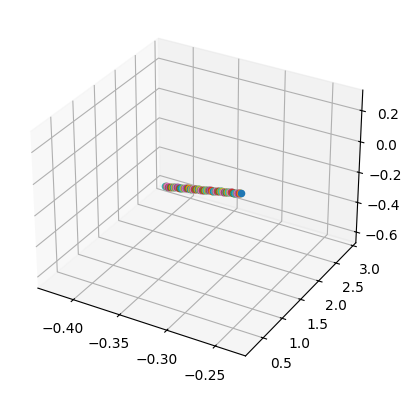

In [688]:
import numpy as np
from scipy.linalg import null_space

H = np.array([[ 3.54802963e+02,  6.97861916e+01, -1.08385010e+02,
         6.40164786e+02],
       [-1.24816861e+00, -1.22047442e+02, -4.31999215e+02,
         2.87002273e+02],
       [ 7.15011146e-04,  1.07872147e-01, -1.14943806e-01,
         1.00000000e+00]])

x = np.array([548, 143, 1])

nullspace = null_space(H).T.squeeze() # computes the null space of the homography
X = np.linalg.lstsq(H, x, rcond=None)[0] # computes a particular solution given 2d point, remember there can be many 3d solutions for each 2d solution


points = [X + t*nullspace for t in np.linspace(0, 2, 100)] # here i generate a set of 3d points that are on the line defined by the nullspace and the particular solution

print(f'X: {X}')
print(f'Nullspace: {nullspace.T.squeeze()}')

result = []
for p in points:
    x_0 = np.dot(H, p) # for each of the generated points i calculate the respective 2d point under the homography

    x_0 = x_0 / x_0[-1]
    x_0 = x_0[:-1]
    p2 = p / p[-1]
    p2 = p2[:-1] # normalizing both 3d and 2d points and converting from homogenous to cartesian

    result.append((x_0,p2))

for r in result:
    print(r) # the result shows that all 3d points mapped to the same 2d point, which confirms its correct

# given this, we can now fixate a quota z and look for the respective x and y that would map to the same 2d point
# plot all 3d points in the tuples in the list

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for r in result:
    ax.scatter(r[1][0], r[1][1], r[1][2])

plt.show()


In [576]:
0.75*0.0525

0.02625

In [703]:
from scipy.linalg import null_space

nullspace = null_space(H).T.squeeze()

def find_intersection(X_0, X_1, quota):
    t = (quota - X_0[2]) / (X_1[2] - X_0[2])
    p = X_0 + t * (X_1 - X_0)
    return p

def get_3d_point_at_quota_given_2d(H_nullspace, x, quota):
    X = np.linalg.lstsq(H, x, rcond=None)[0]
    H_nullspace = H_nullspace.reshape(4)
    X_0 = X / X[-1]
    X_0 = X_0[:-1]
    X_1 = X + H_nullspace
    X_1 = X_1 / X_1[-1]
    X_1 = X_1[:-1]
    return find_intersection(X_0, X_1, quota)


x = bpos_color[1][0] # yellow

x = x[::-1] # flipping x and y because of how the homography matrix was computed
x = np.hstack((x, 1))
z = 0.5
p = np.array(get_3d_point_at_quota_given_2d(nullspace, x, z*0.0525))
p



array([-0.29224602,  1.0529086 ,  0.02625   ])

In [710]:
x = bpos_color[3][0] # green

x = x[::-1] # flipping x and y because of how the homography matrix was computed
x = np.hstack((x, 1))

p = np.array(get_3d_point_at_quota_given_2d(nullspace, x, z*0.0525))
p

array([0.28409864, 1.05781042, 0.02625   ])

In [711]:
x = bpos_color[4][0] # blue

x = x[::-1] # flipping x and y because of how the homography matrix was computed
x = np.hstack((x, 1))

p = np.array(get_3d_point_at_quota_given_2d(nullspace, x, z*0.0525))
p

array([-0.0015247,  0.0233249,  0.02625  ])

In [722]:
x = bpos_color[-1][0] # black

x = x[::-1] # flipping x and y because of how the homography matrix was computed
x = np.hstack((x, 1))
z = 3/4
p = np.array(get_3d_point_at_quota_given_2d(nullspace, x, z*0.0525))
p

array([ 0.00231747, -1.44853444,  0.039375  ])

In [723]:
x = bpos_color[-1][0] # black

x = x[::-1] # flipping x and y because of how the homography matrix was computed
x = np.hstack((x, 1))
z = 0.949851559484536
p = np.array(get_3d_point_at_quota_given_2d(nullspace, x, z*0.0525))
p

array([ 0.00341181, -1.47022179,  0.04986721])

In [ ]:
p = np.array(get_3d_point_at_quota_given_2d(nullspace, bpos_color[1][0], 0.75*0.0525))
print(p)

width of playable area = 1.778
length of playable area = 3.569
width of cushions = 0.0508
height of cushions = 0.0381
height of the ball = 0.0525

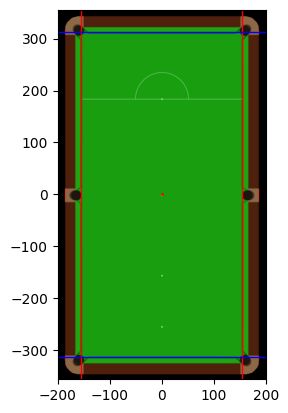

In [676]:
img = cv2.imread('./snooker-table-top-view.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()

height, width = img.shape[:2]
plt.xlim(-width / 2, width / 2)
plt.ylim(-height / 2, height / 2)

plt.imshow(img, extent=(-width / 2, width / 2, (-height / 2) -3, (height / 2) -3))
plt.scatter(0, 0, color='red', s=1)

w = 155
plt.plot([w, w], [-height / 2, height / 2], color='red', linewidth=1)
w2 = -155
plt.plot([w2, w2], [-height / 2, height / 2], color='red', linewidth=1)

h = 312
plt.plot([-width / 2, width / 2], [h, h], color='blue', linewidth=1)
h2 = -312
plt.plot([-width / 2, width / 2], [h2, h2], color='blue', linewidth=1)
plt.show()

width of playable area = 1.778
length of playable area = 3.569
width of cushions = 0.0508
height of cushions = 0.0381
height of the ball = 0.0525
center to baulk line distance = 1.0475
baulk line ccenter (brown ball) to green(right) or yellow(left) distance = 0.292

In [807]:
def referance_mapping(point):
    x, y = point
    p1 = int((x*156/0.889)+200)
    p2 = int((-y*312/1.778)+355)
    return (p1, p2)

def generate_simulation_frame(background_image, ball_poses_colors):
    for position, color in ball_poses_colors:
        cv2.circle(background_image, referance_mapping(position), 7, color, -1)
    return background_image

img = cv2.imread('./snooker-table-top-view.png')
ball_poses_colors = [((-0.29235669, 1.05393455),(0, 255, 255)),((0, 0),(255, 0, 0))]
img2 = generate_simulation_frame(img.copy(), ball_poses_colors)
show_bgr_image(img2)

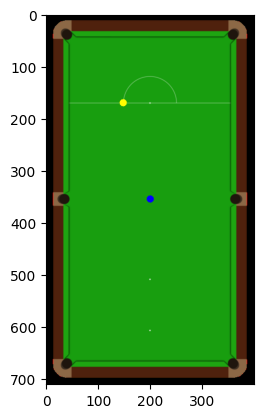

In [806]:
img = cv2.imread('./snooker-table-top-view.png')

ball_poses_colors = [((-0.29235669, 1.05393455),(0, 255, 255)),((0, 0),(255, 0, 0))]

img2 = generate_simulation_frame(img.copy(), ball_poses_colors)
show_bgr_image(img2)

356
667
(148, 170)


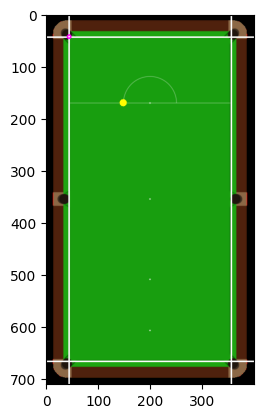

In [799]:
img = cv2.imread('./snooker-table-top-view.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width = img.shape[:2]
#draw a vertical line
x1 = 44
cv2.line(img, (x1, 0), (x1, 711), (255, 255, 255), 2)
x2 = width-x1
print(x2)
cv2.line(img, (x2, 0), (x2, 711), (255, 255, 255), 2)

#draw a horizontal line
y1 = 44
cv2.line(img, (0, y1), (width, y1), (255, 255, 255), 2)
y2 = height-y1
print(y2)
cv2.line(img, (0, y2), (width, y2), (255, 255, 255), 2)

def referance_mapping(point):
    x, y = point
    p1 = int((x*156/0.889)+200)
    p2 = int((-y*312/1.778)+355)
    return (p1, p2)

center = referance_mapping((-0.889, 1.778))
cv2.circle(img, center, 3, (255, 0, 255), 2)

blue = referance_mapping((-0.29235669, 1.05393455))
print(blue)
cv2.circle(img, blue, 7, (255, 255, 0), -1)



#plot the image
plt.figure()
plt.imshow(img)


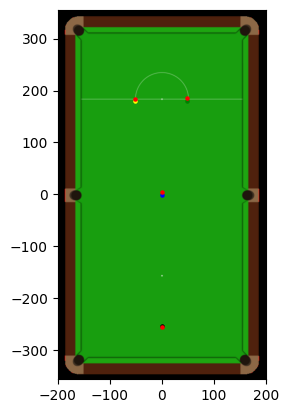

In [726]:
def referance_mapping(point):
    x, y = point
    xr = x*155/0.889
    yr = y*312/1.7845
    return xr, yr

img = cv2.imread('./snooker-table-top-view.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()

height, width = img.shape[:2]
plt.xlim(-width / 2, width / 2)
plt.ylim(-height / 2, height / 2)

#array([-0.00073358, -0.00042169,  0.02525   ])
#array([0.28433908, 1.03206928, 0.02525   ])
#array([-0.29089437,  1.02717692,  0.02525   ])
#array([-0.29235669,  1.05393455,  0.02525   ])
#array([0.28433908, 1.03206928, 0.02525   ]),
#array([-0.00073358, -0.00042169,  0.02525   ])

#array([ 0.00173488, -1.44236621,  0.02525   ])
#array([ 0.00240034, -1.45957171,  0.02525   ])
pt1 = referance_mapping([-0.00073358, -0.00042169]) #blue
pt2 = referance_mapping([0.28433908, 1.03206928]) #green
pt3 = referance_mapping([-0.29089437,  1.02717692]) #yellow
pt4 = referance_mapping([-0.29235669,  1.05393455]) # yellow2
pt5 = referance_mapping([0.28412405, 1.05883753]) #green2
pt6 = referance_mapping([-0.00156672,  0.02410776]) #blue2
pt7 = referance_mapping([ 0.00173488, -1.44236621]) #black
pt8 = referance_mapping([ 0.00240034, -1.45957171]) #black2

plt.imshow(img, extent=(-width / 2, width / 2, (-height / 2) -3, (height / 2) -3))
plt.scatter(pt1[0], pt1[1], color='blue', s=5)
plt.scatter(pt2[0], pt2[1], color='green', s=5)
plt.scatter(pt3[0], pt3[1], color='yellow', s=5)
plt.scatter(pt4[0], pt4[1], color='red', s=5)
plt.scatter(pt5[0], pt5[1], color='red', s=5)
plt.scatter(pt6[0], pt6[1], color='red', s=5)
plt.scatter(pt7[0], pt7[1], color='black', s=5)
plt.scatter(pt8[0], pt8[1], color='red', s=5)

plt.show()

In [731]:
pt7[0]

0.3024818897637795

In [732]:
pt8[0]

0.41850697412823396

In [699]:
print(((3.569/2) - 1.0475) / 3.569)
print(126/624)

0.2065004202857943
0.20192307692307693
